# <a id='toc1_'></a>[TOC](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [TOC](#toc1_)    
- [Imports](#toc2_)    
- [Utility functions](#toc3_)    
- [Loading datasets](#toc4_)    
- [Preparing sample sets](#toc5_)    
- [Data processing with Stanza](#toc6_)    
  - [Natives](#toc6_1_)    
  - [Nonnatives](#toc6_2_)    
  - [Translations](#toc6_3_)    
- [Postprocessing](#toc7_)    
  - [Natives](#toc7_1_)    
  - [Nonnatives](#toc7_2_)    
  - [Translations](#toc7_3_)    
- [Statistics](#toc8_)    
  - [TTR](#toc8_1_)    
    - [Lemmas](#toc8_1_1_)    
    - [Lemmas clean](#toc8_1_2_)    
  - [Unigrams](#toc8_2_)    
    - [Adding custom stop-words](#toc8_2_1_)    
  - [Bigrams](#toc8_3_)    
    - [All bigrams](#toc8_3_1_)    
    - [Bigrams w/o stops](#toc8_3_2_)    
  - [POS](#toc8_4_)    
    - [POS Unigrams](#toc8_4_1_)    
      - [Function words](#toc8_4_1_1_)    
    - [POS bigrams](#toc8_4_2_)    
    - [AN vs. NN frequencies](#toc8_4_3_)    
      - [Alternative version (w/o threshold)](#toc8_4_3_1_)    
  - [Collocations](#toc8_5_)    
    - [Bigrams](#toc8_5_1_)    
    - [Trigrams](#toc8_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [556]:
from collections import Counter
import itertools

In [557]:
from math import log10

In [558]:
import numpy as np
import pandas as pd

In [559]:
import re
import string

In [560]:
import xml.etree.ElementTree as ET

In [561]:
%%capture
!pip install nltk

In [627]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
# from nltk import word_tokenize
# from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.collocations import *
nltk_stopwords_en = stopwords.words('english')
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

[nltk_data] Downloading package punkt to /home/eugene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eugene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/eugene/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [563]:
%%capture
! pip install stanza

In [564]:
#%%capture
import stanza
stanza.download("en")
nlp_stanza = stanza.Pipeline(lang="en", processors="tokenize, pos, lemma")

2025-02-14 12:29:29 INFO: Downloaded file to /home/eugene/stanza_resources/resources.json
2025-02-14 12:29:29 INFO: Downloading default packages for language: en (English) ...
2025-02-14 12:29:32 INFO: File exists: /home/eugene/stanza_resources/en/default.zip
2025-02-14 12:29:40 INFO: Finished downloading models and saved to /home/eugene/stanza_resources
2025-02-14 12:29:40 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-02-14 12:29:40 INFO: Downloaded file to /home/eugene/stanza_resources/resources.json
2025-02-14 12:29:40 WARNING: Language en package default expects mwt, which has been added
2025-02-14 12:29:41 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| l

In [565]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [566]:
%%capture
!pip install lexical-diversity

In [567]:
# https://github.com/kristopherkyle/lexical_diversity
from lexical_diversity import lex_div as ld

# <a id='toc3_'></a>[Utility functions](#toc0_)

In [568]:
ttr = lambda t: len(set(t)) / len(list(t))
log_ttr = lambda t: log10(len(set(t))) / log10(len(list(t)))
n_types = lambda t: len(set(t))

In [569]:
# list[list] -> list
flatten_list = lambda list_of_lists: list(itertools.chain.from_iterable(list_of_lists))

In [570]:
alpha_pattern = re.compile(r'[^ a-zA-Z]+')
filter_alpha = lambda s: alpha_pattern.sub('', s)

In [571]:
filter_alpha('Probably, the world\'s most famous!')

'Probably the worlds most famous'

In [572]:
def filter_list(input: list, stop_list: list) -> list:
    return list(filter(lambda w: w not in stop_list and w, input))

In [573]:
def filter_stop_words(words: list, stops: list) -> list:
    # return list(filter(lambda w: w not in stops and len(w), words))
    return filter_list(words, stops)

# <a id='toc4_'></a>[Loading datasets](#toc0_)

This dataset is available at https://github.com/senisioi/enntt-release

See also https://nlp.unibuc.ro/resources.html#ENNTT

In [574]:
# detect if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [575]:
# mount Google Drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [576]:
# corpus data location
if IN_COLAB:
    DATA_DIR = '/content/drive/MyDrive/Data/ENNTT/'
else:
    DATA_DIR = './ENNTT/'

In [577]:
# reads ENNTT XML .dat files
def read_dat_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        xml = '<data>' + file.read() + '</data>'
    root = ET.fromstring(xml)
    res = [{'lang': child.attrib['LANGUAGE'], 'state': child.attrib['STATE'] if 'STATE' in child.attrib else None} for child in root]
    return res


In [578]:
# reads ENNTT TXT .tok files
def read_tok_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        res = [{'text': line.strip()} for line in file]
    return res

In [579]:
def load_dataset(name):
    filename = name + '.tok'
    filepath = DATA_DIR + filename
    dic_tok = read_tok_file(filepath)

    filename = name + '.dat'
    filepath = DATA_DIR + filename
    dic_dat = read_dat_file(filepath)

    df_tok = pd.DataFrame(dic_tok)
    df_dat = pd.DataFrame(dic_dat)

    df = pd.concat([df_tok, df_dat], axis = 1)

    return df


In [580]:
df_natives = load_dataset('natives')
df_natives

text lang           state
0       You will be aware from the press and televisio...   EN  United Kingdom
1       One of the people assassinated very recently i...   EN  United Kingdom
2       Would it be appropriate for you , Madam Presid...   EN  United Kingdom
3       I would like your advice about Rule 143 concer...   EN  United Kingdom
4       My question relates to something that will com...   EN  United Kingdom
...                                                   ...  ...             ...
116336  Increasingly , rather than screaming at the in...   EN         Ireland
116337  That does not mean that we want to bring an en...   EN         Ireland
116338  For example , there is the pigmeat industry wh...   EN         Ireland
116339  Prices collapse , there is terrible hardship a...   EN         Ireland
116340  If we had good statistics , we would be able t...   EN         Ireland

[116341 rows x 3 columns]

In [581]:
df_nonnatives = load_dataset('nonnatives')
df_nonnatives

text lang    state
0      The Commission is following with interest the ...   EN  Belgium
1      According to our information , the decision on...   EN  Belgium
2      The Commission acknowledges the fact that Turk...   EN  Belgium
3      The Commission does not have a mandate to impo...   EN  Belgium
4      As Commissioner Wallström indicated during the...   EN  Belgium
...                                                  ...  ...      ...
29729  Once again , I can confirm that the Council , ...   EN  Estonia
29730  Madam President , you have just completed your...   EN  Estonia
29731  There remain a few differences between our ins...   EN  Estonia
29732  However , the Council can accept the amendment...   EN  Estonia
29733  Mr President , I am presenting a written expla...   EN   Sweden

[29734 rows x 3 columns]

In [582]:
df_translations = load_dataset('translations')
df_translations

text lang state
0       Madam President , coinciding with this year ' ...   IT  None
1       This is all in accordance with the principles ...   IT  None
2       All of us here are pleased that the courts hav...   DE  None
3       Now , however , he is to go before the courts ...   DE  None
4       We know , and we have stated as much in very m...   DE  None
...                                                   ...  ...   ...
738592                    Would you please rectify this ?   FR  None
738593  Mr President , as it is now Christmas , I woul...   DE  None
738594  I would like to thank you and clear up a misun...   DE  None
738595  The President is entitled to allow an MEP to a...   DE  None
738596  Mr President , I would like to take this oppor...   NL  None

[738597 rows x 3 columns]

In [583]:
df_natives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116341 entries, 0 to 116340
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    116341 non-null  object
 1   lang    116341 non-null  object
 2   state   116341 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


In [584]:
df_nonnatives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29734 entries, 0 to 29733
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29734 non-null  object
 1   lang    29734 non-null  object
 2   state   29734 non-null  object
dtypes: object(3)
memory usage: 697.0+ KB


In [585]:
df_translations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738597 entries, 0 to 738596
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    738597 non-null  object
 1   lang    738597 non-null  object
 2   state   0 non-null       object
dtypes: object(3)
memory usage: 16.9+ MB


In [586]:
df_natives.describe()

text    lang  \
count                                              116341  116341   
unique                                             116334       1   
top     Mr President , I congratulate the rapporteur o...      EN   
freq                                                    2  116341   

                 state  
count           116341  
unique               2  
top     United Kingdom  
freq             89492

In [587]:
df_nonnatives.describe()

text   lang    state
count                                               29734  29734    29734
unique                                              29734      1       25
top     Mr President , I am presenting a written expla...     EN  Finland
freq                                                    1  29734     3292

In [588]:
df_translations.describe()

text    lang state
count                       738597  738597     0
unique                      738560      25     0
top     Thank you , Mr President .      DE   NaN
freq                             5  155498   NaN

In [589]:
df_natives['state'].value_counts()

state
United Kingdom    89492
Ireland           26849
Name: count, dtype: int64

<Axes: title={'center': 'Natives'}, xlabel='state'>

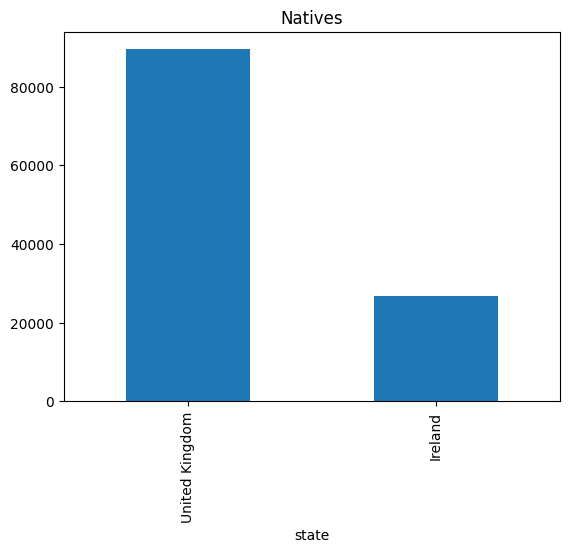

In [596]:
df_natives['state'].value_counts().plot(kind="bar", title="Natives")

In [590]:
df_nonnatives['state'].value_counts()

state
Finland           3292
Netherlands       2658
Belgium           2560
Sweden            2055
Estonia           2024
Portugal          1871
Spain             1761
Luxembourg        1658
Malta             1524
Hungary           1441
Poland            1389
Cyprus            1213
France            1149
Romania           1049
Germany            671
Denmark            618
Lithuania          611
Italy              554
Latvia             495
Greece             461
Slovakia           204
Bulgaria           200
Czech Republic     159
Austria             76
Slovenia            41
Name: count, dtype: int64

<Axes: title={'center': 'Non-natives'}, xlabel='state'>

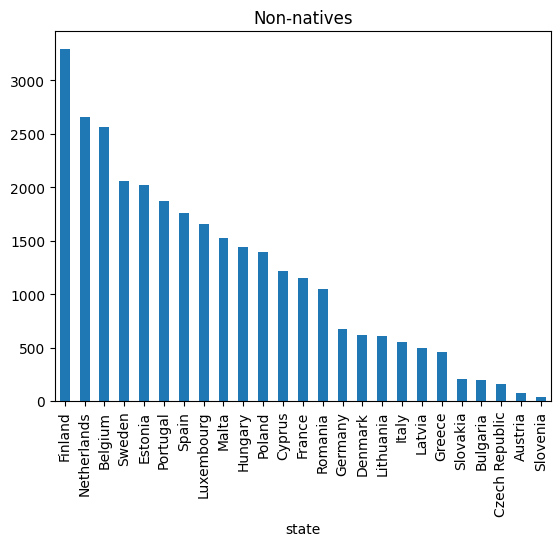

In [595]:
df_nonnatives['state'].value_counts().plot(kind="bar", title="Non-natives")

In [591]:
df_translations['lang'].value_counts()

lang
DE                   155498
FR                   132900
NL                    82890
ES                    65628
IT                    56511
PT                    55023
SV                    43031
EL                    34462
FI                    22082
PL                    21913
DA                    18928
RO                     9027
Unknown(conflict)      8169
CS                     7832
HU                     6850
LT                     6686
SK                     3563
SL                     1739
LV                     1484
ET                     1352
MT                     1119
BG                      967
GA                      915
GR                       24
CA                        4
Name: count, dtype: int64

# <a id='toc5_'></a>[Preparing sample sets](#toc0_)

In [ ]:
# sample exactly n_samples rows of each unique value of the column specified (value omitted if not enough rows)
def sample_data(in_df: pd.DataFrame, n_samples: int, column: str) -> pd.DataFrame:
    unique_list = in_df[column].unique()
    res_df = pd.DataFrame()
    for value in unique_list:
        df = in_df[in_df[column] == value]
        if df.shape[0] >= n_samples:
            res_df = pd.concat([res_df, df.sample(n_samples)])
    return res_df


In [ ]:
# df_natives_sample = df_natives.sample(2000)
# df_natives_sample

In [ ]:
df_natives_sample = sample_data(df_natives, 2000, 'state')
df_natives_sample

text lang           state
77995   We therefore need Russia 's help to persuade I...   EN  United Kingdom
114792  - Perhaps I should start with a historical , n...   EN  United Kingdom
76955   Overall the EPLP feels that this report did no...   EN  United Kingdom
11335   Finally , have you had any reports from the FV...   EN  United Kingdom
9587    Now we have expressed our concerns about the E...   EN  United Kingdom
...                                                   ...  ...             ...
109773  Mr President , I thank you for your very kind ...   EN         Ireland
105647  But if Mr Primakov and his administration do t...   EN         Ireland
21682   Regarding market state responsibility , the EU...   EN         Ireland
89667   Is it the legitimate forces of law and order o...   EN         Ireland
69650   Rather than criticising or pointing the finger...   EN         Ireland

[4000 rows x 3 columns]

In [ ]:
df_natives_sample['state'].value_counts()

state
United Kingdom    2000
Ireland           2000
Name: count, dtype: int64

In [ ]:
# df_nonnatives_sample = df_nonnatives.sample(1000)
# df_nonnatives_sample

In [ ]:
df_nonnatives_sample = sample_data(df_nonnatives, 1149, 'state')
df_nonnatives_sample

text lang    state
16103  The outcome of this analysis is expected to be...   EN  Belgium
17353  Being a Member State of the European Union als...   EN  Belgium
16266  If , in the end , it is not possible , then of...   EN  Belgium
26460  It is not enough to say 13 people and one of A...   EN  Belgium
26193  Other issues have been raised , Madam Presiden...   EN  Belgium
...                                                  ...  ...      ...
23902  in writing . - I urge the Hungarian Presidency...   EN  Estonia
6309   I hope we can settle some of the outstanding q...   EN  Estonia
14371  I find it absolutely outrageous that in the 21...   EN  Estonia
11744  We are trying to promote the idea and do whate...   EN  Estonia
6308   As I said , and as you all know , in July we w...   EN  Estonia

[14937 rows x 3 columns]

In [ ]:
# df_translations_sample = df_translations.sample(100)
# df_translations_sample

In [ ]:
df_translations_sample = sample_data(df_translations, 1119, 'lang')
df_translations_sample

text lang state
238610  Mr President , Mr President of the Commission ...   IT  None
76401   It was so good that I got friendly with the ow...   IT  None
552812  I think , especially in light of recent events...   IT  None
732371  It is therefore impossible to determine to wha...   IT  None
601474  This cooperation was mentioned a little earlie...   IT  None
...                                                   ...  ...   ...
442881  Due to the 2005 introduction of the single tax...   RO  None
472774  ` Freedom of the press is essential to a democ...   RO  None
554568  Nuclear energy has an important role to play i...   RO  None
544247  The European Union must face up to the reality...   RO  None
476540  Cooperation between the European Ombudsman and...   RO  None

[23499 rows x 3 columns]

# <a id='toc6_'></a>[Data processing with Stanza](#toc0_)

[!CAUTION] This section is computationally challenging, a CUDA environment is highly recommended!

In [ ]:
# extracts no. tokens + lists of lemmas, POS (w/o puctuation!) and POS bigrams
def extract_lemmas_pos(row: pd.Series, filter_tokens: bool = False, stops: list = nltk_stopwords_en) -> tuple[int, list, list, list]:
    text_stanza = nlp_stanza(row.text)
    lemma_list, pos_list = [], []
    for sentence in text_stanza.iter_tokens():
        for token in sentence.words:
            if (not filter_tokens or token.lemma.lower() not in stops):  #token.upos != "PUNCT" and
                lemma_list.append(token.lemma)
                pos_list.append(token.upos)
    # pos_bigrams = list(nltk.bigrams(pos_list))
    return len(lemma_list), lemma_list, pos_list #, pos_bigrams


## <a id='toc6_1_'></a>[Natives](#toc0_)

In [ ]:
%%time
df_natives_sample[['n_tokens', 'lemmas', 'pos']] = df_natives_sample.apply(extract_lemmas_pos, axis=1, result_type='expand')
df_natives_sample

CPU times: user 16min 42s, sys: 800 ms, total: 16min 43s
Wall time: 16min 43s


text lang  \
77995   We therefore need Russia 's help to persuade I...   EN   
114792  - Perhaps I should start with a historical , n...   EN   
76955   Overall the EPLP feels that this report did no...   EN   
11335   Finally , have you had any reports from the FV...   EN   
9587    Now we have expressed our concerns about the E...   EN   
...                                                   ...  ...   
109773  Mr President , I thank you for your very kind ...   EN   
105647  But if Mr Primakov and his administration do t...   EN   
21682   Regarding market state responsibility , the EU...   EN   
89667   Is it the legitimate forces of law and order o...   EN   
69650   Rather than criticising or pointing the finger...   EN   

                 state  n_tokens  \
77995   United Kingdom        15   
114792  United Kingdom        37   
76955   United Kingdom        48   
11335   United Kingdom        28   
9587    United Kingdom        28   
...                ...       ...   
109773         Ireland        36   
105647         Ireland        20   
21682          Ireland        19   
89667          Ireland        33   
69650          Ireland        40   

                                                   lemmas  \
77995   [we, therefore, need, Russia, 's, help, to, pe...   
114792  [-, perhaps, I, should, start, with, a, histor...   
76955   [overall, the, EPLP, feel, that, this, report,...   
11335   [finally, ,, have, you, have, any, report, fro...   
9587    [now, we, have, express, our, concern, about, ...   
...                                                   ...   
109773  [Mr, President, ,, I, thank, you, for, your, v...   
105647  [but, if, Mr, Primakov, and, his, administrati...   
21682   [regard, market, state, responsibility, ,, the...   
89667   [be, it, the, legitimate, force, of, law, and,...   
69650   [rather, than, criticise, or, point, the, fing...   

                                                      pos  \
77995   [PRON, ADV, VERB, PROPN, PART, NOUN, PART, VER...   
114792  [PUNCT, ADV, PRON, AUX, VERB, ADP, DET, ADJ, P...   
76955   [ADV, DET, PROPN, VERB, SCONJ, DET, NOUN, AUX,...   
11335   [ADV, PUNCT, AUX, PRON, VERB, DET, NOUN, ADP, ...   
9587    [ADV, PRON, AUX, VERB, PRON, NOUN, ADP, DET, P...   
...                                                   ...   
109773  [PROPN, PROPN, PUNCT, PRON, VERB, PRON, ADP, P...   
105647  [CCONJ, SCONJ, PROPN, PROPN, CCONJ, PRON, NOUN...   
21682   [VERB, NOUN, NOUN, NOUN, PUNCT, DET, PROPN, AU...   
89667   [AUX, PRON, DET, ADJ, NOUN, ADP, NOUN, CCONJ, ...   
69650   [ADV, ADP, VERB, CCONJ, VERB, DET, NOUN, CCONJ...   

                                              pos_bigrams  
77995   [(PRON, ADV), (ADV, VERB), (VERB, PROPN), (PRO...  
114792  [(PUNCT, ADV), (ADV, PRON), (PRON, AUX), (AUX,...  
76955   [(ADV, DET), (DET, PROPN), (PROPN, VERB), (VER...  
11335   [(ADV, PUNCT), (PUNCT, AUX), (AUX, PRON), (PRO...  
9587    [(ADV, PRON), (PRON, AUX), (AUX, VERB), (VERB,...  
...                                                   ...  
109773  [(PROPN, PROPN), (PROPN, PUNCT), (PUNCT, PRON)...  
105647  [(CCONJ, SCONJ), (SCONJ, PROPN), (PROPN, PROPN...  
21682   [(VERB, NOUN), (NOUN, NOUN), (NOUN, NOUN), (NO...  
89667   [(AUX, PRON), (PRON, DET), (DET, ADJ), (ADJ, N...  
69650   [(ADV, ADP), (ADP, VERB), (VERB, CCONJ), (CCON...  

[4000 rows x 7 columns]

## <a id='toc6_2_'></a>[Nonnatives](#toc0_)

In [ ]:
%%time
df_nonnatives_sample[['n_tokens', 'lemmas', 'pos']] = df_nonnatives_sample.apply(extract_lemmas_pos, axis=1, result_type='expand')
df_nonnatives_sample

CPU times: user 1h 10min 1s, sys: 7.88 s, total: 1h 10min 9s
Wall time: 1h 10min 9s


text lang    state  \
16103  The outcome of this analysis is expected to be...   EN  Belgium   
17353  Being a Member State of the European Union als...   EN  Belgium   
16266  If , in the end , it is not possible , then of...   EN  Belgium   
26460  It is not enough to say 13 people and one of A...   EN  Belgium   
26193  Other issues have been raised , Madam Presiden...   EN  Belgium   
...                                                  ...  ...      ...   
23902  in writing . - I urge the Hungarian Presidency...   EN  Estonia   
6309   I hope we can settle some of the outstanding q...   EN  Estonia   
14371  I find it absolutely outrageous that in the 21...   EN  Estonia   
11744  We are trying to promote the idea and do whate...   EN  Estonia   
6308   As I said , and as you all know , in July we w...   EN  Estonia   

       n_tokens                                             lemmas  \
16103        24  [the, outcome, of, this, analysis, be, expect,...   
17353        13  [be, a, Member, State, of, the, European, Unio...   
16266        28  [if, ,, in, the, end, ,, it, be, not, possible...   
26460        29  [it, be, not, enough, to, say, 13, person, and...   
26193        27  [other, issue, have, be, raise, ,, Madam, Pres...   
...         ...                                                ...   
23902        27  [in, writing, ., -, I, urge, the, Hungarian, P...   
6309         14  [I, hope, we, can, settle, some, of, the, outs...   
14371        28  [I, find, it, absolutely, outrageous, that, in...   
11744        36  [we, be, try, to, promote, the, idea, and, do,...   
6308         30  [as, I, say, ,, and, as, you, all, know, ,, in...   

                                                     pos  \
16103  [DET, NOUN, ADP, DET, NOUN, AUX, VERB, PART, A...   
17353  [AUX, DET, PROPN, PROPN, ADP, DET, ADJ, PROPN,...   
16266  [SCONJ, PUNCT, ADP, DET, NOUN, PUNCT, PRON, AU...   
26460  [PRON, AUX, PART, ADJ, PART, VERB, NUM, NOUN, ...   
26193  [ADJ, NOUN, AUX, AUX, VERB, PUNCT, PROPN, PROP...   
...                                                  ...   
23902  [ADP, NOUN, PUNCT, PUNCT, PRON, VERB, DET, ADJ...   
6309   [PRON, VERB, PRON, AUX, VERB, DET, ADP, DET, A...   
14371  [PRON, VERB, PRON, ADV, ADJ, SCONJ, ADP, DET, ...   
11744  [PRON, AUX, VERB, PART, VERB, DET, NOUN, CCONJ...   
6308   [SCONJ, PRON, VERB, PUNCT, CCONJ, SCONJ, PRON,...   

                                             pos_bigrams  
16103  [(DET, NOUN), (NOUN, ADP), (ADP, DET), (DET, N...  
17353  [(AUX, DET), (DET, PROPN), (PROPN, PROPN), (PR...  
16266  [(SCONJ, PUNCT), (PUNCT, ADP), (ADP, DET), (DE...  
26460  [(PRON, AUX), (AUX, PART), (PART, ADJ), (ADJ, ...  
26193  [(ADJ, NOUN), (NOUN, AUX), (AUX, AUX), (AUX, V...  
...                                                  ...  
23902  [(ADP, NOUN), (NOUN, PUNCT), (PUNCT, PUNCT), (...  
6309   [(PRON, VERB), (VERB, PRON), (PRON, AUX), (AUX...  
14371  [(PRON, VERB), (VERB, PRON), (PRON, ADV), (ADV...  
11744  [(PRON, AUX), (AUX, VERB), (VERB, PART), (PART...  
6308   [(SCONJ, PRON), (PRON, VERB), (VERB, PUNCT), (...  

[14937 rows x 7 columns]

## <a id='toc6_3_'></a>[Translations](#toc0_)

In [ ]:
%%time
df_translations_sample[['n_tokens', 'lemmas', 'pos']] = df_translations_sample.apply(extract_lemmas_pos, axis=1, result_type='expand')
df_translations_sample

CPU times: user 1h 57min 36s, sys: 5.94 s, total: 1h 57min 42s
Wall time: 1h 57min 42s


text lang state  \
238610  Mr President , Mr President of the Commission ...   IT  None   
76401   It was so good that I got friendly with the ow...   IT  None   
552812  I think , especially in light of recent events...   IT  None   
732371  It is therefore impossible to determine to wha...   IT  None   
601474  This cooperation was mentioned a little earlie...   IT  None   
...                                                   ...  ...   ...   
442881  Due to the 2005 introduction of the single tax...   RO  None   
472774  ` Freedom of the press is essential to a democ...   RO  None   
554568  Nuclear energy has an important role to play i...   RO  None   
544247  The European Union must face up to the reality...   RO  None   
476540  Cooperation between the European Ombudsman and...   RO  None   

        n_tokens                                             lemmas  \
238610        64  [Mr, President, ,, Mr, President, of, the, Com...   
76401         18  [it, be, so, good, that, I, get, friendly, wit...   
552812        37  [I, think, ,, especially, in, light, of, recen...   
732371        17  [it, be, therefore, impossible, to, determine,...   
601474        53  [this, cooperation, be, mention, a, little, ea...   
...          ...                                                ...   
442881        33  [due, to, the, 2005, introduction, of, the, si...   
472774        12  [`, freedom, of, the, press, be, essential, to...   
554568        30  [Nuclear, energy, have, a, important, role, to...   
544247        53  [the, European, Union, must, face, up, to, the...   
476540        12  [Cooperation, between, the, European, Ombudsma...   

                                                      pos  \
238610  [PROPN, PROPN, PUNCT, PROPN, PROPN, ADP, DET, ...   
76401   [PRON, AUX, ADV, ADJ, SCONJ, PRON, VERB, ADJ, ...   
552812  [PRON, VERB, PUNCT, ADV, ADP, NOUN, ADP, ADJ, ...   
732371  [PRON, AUX, ADV, ADJ, PART, VERB, ADP, DET, NO...   
601474  [DET, NOUN, AUX, VERB, DET, ADJ, ADV, ADP, PRO...   
...                                                   ...   
442881  [ADJ, ADP, DET, NUM, NOUN, ADP, DET, ADJ, NOUN...   
472774  [PUNCT, NOUN, ADP, DET, NOUN, AUX, ADJ, ADP, D...   
554568  [ADJ, NOUN, VERB, DET, ADJ, NOUN, PART, VERB, ...   
544247  [DET, ADJ, PROPN, AUX, VERB, ADP, ADP, DET, NO...   
476540  [NOUN, ADP, DET, ADJ, PROPN, CCONJ, PROPN, NOU...   

                                              pos_bigrams  
238610  [(PROPN, PROPN), (PROPN, PUNCT), (PUNCT, PROPN...  
76401   [(PRON, AUX), (AUX, ADV), (ADV, ADJ), (ADJ, SC...  
552812  [(PRON, VERB), (VERB, PUNCT), (PUNCT, ADV), (A...  
732371  [(PRON, AUX), (AUX, ADV), (ADV, ADJ), (ADJ, PA...  
601474  [(DET, NOUN), (NOUN, AUX), (AUX, VERB), (VERB,...  
...                                                   ...  
442881  [(ADJ, ADP), (ADP, DET), (DET, NUM), (NUM, NOU...  
472774  [(PUNCT, NOUN), (NOUN, ADP), (ADP, DET), (DET,...  
554568  [(ADJ, NOUN), (NOUN, VERB), (VERB, DET), (DET,...  
544247  [(DET, ADJ), (ADJ, PROPN), (PROPN, AUX), (AUX,...  
476540  [(NOUN, ADP), (ADP, DET), (DET, ADJ), (ADJ, PR...  

[23499 rows x 7 columns]

In [ ]:
# Dumping data to files
df_natives_sample.to_csv("df_natives_sample.csv")
df_nonnatives_sample.to_csv("df_nonnatives_sample.csv")
df_translations_sample.to_csv("df_translations_sample.csv")

# <a id='toc7_'></a>[Postprocessing](#toc0_)

In [26]:
# convert string to list of strings when reading from a CSV file
str2list_str = lambda x: x.strip("[]").replace("'", "").split(", ")

In [27]:
# del df_natives_sample
# del df_nonnatives_sample
# del df_translations_sample

In [28]:
# Restoring from backup files if DataFrames not existent
if 'df_natives_sample' not in globals():
    df_natives_sample = pd.read_csv("df_natives_sample.csv", converters={"lemmas": str2list_str, "pos": str2list_str})
if 'df_nonnatives_sample' not in globals():
    df_nonnatives_sample = pd.read_csv("df_nonnatives_sample.csv", converters={"lemmas": str2list_str, "pos": str2list_str})
if 'df_translations_sample' not in globals():
    df_translations_sample = pd.read_csv("df_translations_sample.csv", keep_default_na=False, converters={"lemmas": str2list_str, "pos": str2list_str})

In [29]:
# filtering out: numbers, punctuation, stop-words
def filter_token_list(tokens: list, stops: list = nltk_stopwords_en) -> list:
    words = [filter_alpha(t.lower()) for t in tokens if t not in string.punctuation]
    return filter_stop_words(words, stops)

In [30]:
filter_token_list(['a', 'be', 'hello', 'I', ',', '\'s', 'Mr', '1997'])

['hello', 'mr']

In [369]:
# filtering out some parts of speech and counting AN, NN bigrams
def df_postprocessing(df):
    df['bigrams'] = df.lemmas.apply(lambda x: list(nltk.bigrams(x)))
    df['pos_bigrams'] = df.pos.apply(lambda x: list(nltk.bigrams(x)))
    # df['n_bigrams'] = df['n_tokens'] - 1
    df['n_bigrams'] = df.bigrams.apply(len)
    df['NN_count'] = df.pos_bigrams.apply(lambda x: x.count(('NOUN','NOUN')))
    df['AN_count'] = df.pos_bigrams.apply(lambda x: x.count(('ADJ','NOUN')))
    df['pos_clean'] = df.pos.apply(lambda x: filter_list(x, ['NUM', 'PUNCT', 'SYM', 'X']))

## <a id='toc7_1_'></a>[Natives](#toc0_)

In [370]:
df_natives_sample['lemmas_clean'] = df_natives_sample.lemmas.apply(filter_token_list)
df_natives_sample

Unnamed: 0                                               text lang  \
0          77995  We therefore need Russia 's help to persuade I...   EN   
1         114792  - Perhaps I should start with a historical , n...   EN   
2          76955  Overall the EPLP feels that this report did no...   EN   
3          11335  Finally , have you had any reports from the FV...   EN   
4           9587  Now we have expressed our concerns about the E...   EN   
...          ...                                                ...  ...   
3995      109773  Mr President , I thank you for your very kind ...   EN   
3996      105647  But if Mr Primakov and his administration do t...   EN   
3997       21682  Regarding market state responsibility , the EU...   EN   
3998       89667  Is it the legitimate forces of law and order o...   EN   
3999       69650  Rather than criticising or pointing the finger...   EN   

               state  n_tokens  \
0     United Kingdom        15   
1     United Kingdom        37   
2     United Kingdom        48   
3     United Kingdom        28   
4     United Kingdom        28   
...              ...       ...   
3995         Ireland        36   
3996         Ireland        20   
3997         Ireland        19   
3998         Ireland        33   
3999         Ireland        40   

                                                 lemmas  \
0     [we, therefore, need, Russia, "s", help, to, p...   
1     [-, perhaps, I, should, start, with, a, histor...   
2     [overall, the, EPLP, feel, that, this, report,...   
3     [finally, ,, have, you, have, any, report, fro...   
4     [now, we, have, express, our, concern, about, ...   
...                                                 ...   
3995  [Mr, President, ,, I, thank, you, for, your, v...   
3996  [but, if, Mr, Primakov, and, his, administrati...   
3997  [regard, market, state, responsibility, ,, the...   
3998  [be, it, the, legitimate, force, of, law, and,...   
3999  [rather, than, criticise, or, point, the, fing...   

                                                    pos  \
0     [PRON, ADV, VERB, PROPN, PART, NOUN, PART, VER...   
1     [PUNCT, ADV, PRON, AUX, VERB, ADP, DET, ADJ, P...   
2     [ADV, DET, PROPN, VERB, SCONJ, DET, NOUN, AUX,...   
3     [ADV, PUNCT, AUX, PRON, VERB, DET, NOUN, ADP, ...   
4     [ADV, PRON, AUX, VERB, PRON, NOUN, ADP, DET, P...   
...                                                 ...   
3995  [PROPN, PROPN, PUNCT, PRON, VERB, PRON, ADP, P...   
3996  [CCONJ, SCONJ, PROPN, PROPN, CCONJ, PRON, NOUN...   
3997  [VERB, NOUN, NOUN, NOUN, PUNCT, DET, PROPN, AU...   
3998  [AUX, PRON, DET, ADJ, NOUN, ADP, NOUN, CCONJ, ...   
3999  [ADV, ADP, VERB, CCONJ, VERB, DET, NOUN, CCONJ...   

                                            pos_bigrams  \
0     [(PRON, ADV), (ADV, VERB), (VERB, PROPN), (PRO...   
1     [(PUNCT, ADV), (ADV, PRON), (PRON, AUX), (AUX,...   
2     [(ADV, DET), (DET, PROPN), (PROPN, VERB), (VER...   
3     [(ADV, PUNCT), (PUNCT, AUX), (AUX, PRON), (PRO...   
4     [(ADV, PRON), (PRON, AUX), (AUX, VERB), (VERB,...   
...                                                 ...   
3995  [(PROPN, PROPN), (PROPN, PUNCT), (PUNCT, PRON)...   
3996  [(CCONJ, SCONJ), (SCONJ, PROPN), (PROPN, PROPN...   
3997  [(VERB, NOUN), (NOUN, NOUN), (NOUN, NOUN), (NO...   
3998  [(AUX, PRON), (PRON, DET), (DET, ADJ), (ADJ, N...   
3999  [(ADV, ADP), (ADP, VERB), (VERB, CCONJ), (CCON...   

                                           lemmas_clean  n_bigrams  NN_count  \
0     [therefore, need, russia, help, persuade, iran...         14         0   
1     [perhaps, start, historical, current, declarat...         36         0   
2     [overall, eplp, feel, report, enhance, capabil...         47         1   
3     [finally, report, fvo, dublin, yet, concern, c...         27         0   
4     [express, concern, eu, meddling, military, mat...         27         0   
...                                                 ...        ...       ... 

In [194]:
df_postprocessing(df_natives_sample)
df_natives_sample

Unnamed: 0                                               text lang  \
0          77995  We therefore need Russia 's help to persuade I...   EN   
1         114792  - Perhaps I should start with a historical , n...   EN   
2          76955  Overall the EPLP feels that this report did no...   EN   
3          11335  Finally , have you had any reports from the FV...   EN   
4           9587  Now we have expressed our concerns about the E...   EN   
...          ...                                                ...  ...   
3995      109773  Mr President , I thank you for your very kind ...   EN   
3996      105647  But if Mr Primakov and his administration do t...   EN   
3997       21682  Regarding market state responsibility , the EU...   EN   
3998       89667  Is it the legitimate forces of law and order o...   EN   
3999       69650  Rather than criticising or pointing the finger...   EN   

               state  n_tokens  \
0     United Kingdom        15   
1     United Kingdom        37   
2     United Kingdom        48   
3     United Kingdom        28   
4     United Kingdom        28   
...              ...       ...   
3995         Ireland        36   
3996         Ireland        20   
3997         Ireland        19   
3998         Ireland        33   
3999         Ireland        40   

                                                 lemmas  \
0     [we, therefore, need, Russia, "s", help, to, p...   
1     [-, perhaps, I, should, start, with, a, histor...   
2     [overall, the, EPLP, feel, that, this, report,...   
3     [finally, ,, have, you, have, any, report, fro...   
4     [now, we, have, express, our, concern, about, ...   
...                                                 ...   
3995  [Mr, President, ,, I, thank, you, for, your, v...   
3996  [but, if, Mr, Primakov, and, his, administrati...   
3997  [regard, market, state, responsibility, ,, the...   
3998  [be, it, the, legitimate, force, of, law, and,...   
3999  [rather, than, criticise, or, point, the, fing...   

                                                    pos  \
0     [PRON, ADV, VERB, PROPN, PART, NOUN, PART, VER...   
1     [PUNCT, ADV, PRON, AUX, VERB, ADP, DET, ADJ, P...   
2     [ADV, DET, PROPN, VERB, SCONJ, DET, NOUN, AUX,...   
3     [ADV, PUNCT, AUX, PRON, VERB, DET, NOUN, ADP, ...   
4     [ADV, PRON, AUX, VERB, PRON, NOUN, ADP, DET, P...   
...                                                 ...   
3995  [PROPN, PROPN, PUNCT, PRON, VERB, PRON, ADP, P...   
3996  [CCONJ, SCONJ, PROPN, PROPN, CCONJ, PRON, NOUN...   
3997  [VERB, NOUN, NOUN, NOUN, PUNCT, DET, PROPN, AU...   
3998  [AUX, PRON, DET, ADJ, NOUN, ADP, NOUN, CCONJ, ...   
3999  [ADV, ADP, VERB, CCONJ, VERB, DET, NOUN, CCONJ...   

                                            pos_bigrams  \
0     [(PRON, ADV), (ADV, VERB), (VERB, PROPN), (PRO...   
1     [(PUNCT, ADV), (ADV, PRON), (PRON, AUX), (AUX,...   
2     [(ADV, DET), (DET, PROPN), (PROPN, VERB), (VER...   
3     [(ADV, PUNCT), (PUNCT, AUX), (AUX, PRON), (PRO...   
4     [(ADV, PRON), (PRON, AUX), (AUX, VERB), (VERB,...   
...                                                 ...   
3995  [(PROPN, PROPN), (PROPN, PUNCT), (PUNCT, PRON)...   
3996  [(CCONJ, SCONJ), (SCONJ, PROPN), (PROPN, PROPN...   
3997  [(VERB, NOUN), (NOUN, NOUN), (NOUN, NOUN), (NO...   
3998  [(AUX, PRON), (PRON, DET), (DET, ADJ), (ADJ, N...   
3999  [(ADV, ADP), (ADP, VERB), (VERB, CCONJ), (CCON...   

                                           lemmas_clean  n_bigrams  NN_count  \
0     [therefore, need, russia, help, persuade, iran...         14         0   
1     [perhaps, start, historical, current, declarat...         36         0   
2     [overall, eplp, feel, report, enhance, capabil...         47         1   
3     [finally, report, fvo, dublin, yet, concern, c...         27         0   
4     [express, concern, eu, meddling, military, mat...         27         0   
...                                                 ...        ...       ... 

## <a id='toc7_2_'></a>[Nonnatives](#toc0_)

In [371]:
df_nonnatives_sample['lemmas_clean'] = df_nonnatives_sample.lemmas.apply(filter_token_list)
df_nonnatives_sample

Unnamed: 0                                               text lang  \
0           16103  The outcome of this analysis is expected to be...   EN   
1           17353  Being a Member State of the European Union als...   EN   
2           16266  If , in the end , it is not possible , then of...   EN   
3           26460  It is not enough to say 13 people and one of A...   EN   
4           26193  Other issues have been raised , Madam Presiden...   EN   
...           ...                                                ...  ...   
14932       23902  in writing . - I urge the Hungarian Presidency...   EN   
14933        6309  I hope we can settle some of the outstanding q...   EN   
14934       14371  I find it absolutely outrageous that in the 21...   EN   
14935       11744  We are trying to promote the idea and do whate...   EN   
14936        6308  As I said , and as you all know , in July we w...   EN   

         state  n_tokens                                             lemmas  \
0      Belgium        24  [the, outcome, of, this, analysis, be, expect,...   
1      Belgium        13  [be, a, Member, State, of, the, European, Unio...   
2      Belgium        28  [if, ,, in, the, end, ,, it, be, not, possible...   
3      Belgium        29  [it, be, not, enough, to, say, 13, person, and...   
4      Belgium        27  [other, issue, have, be, raise, ,, Madam, Pres...   
...        ...       ...                                                ...   
14932  Estonia        27  [in, writing, ., -, I, urge, the, Hungarian, P...   
14933  Estonia        14  [I, hope, we, can, settle, some, of, the, outs...   
14934  Estonia        28  [I, find, it, absolutely, outrageous, that, in...   
14935  Estonia        36  [we, be, try, to, promote, the, idea, and, do,...   
14936  Estonia        30  [as, I, say, ,, and, as, you, all, know, ,, in...   

                                                     pos  \
0      [DET, NOUN, ADP, DET, NOUN, AUX, VERB, PART, A...   
1      [AUX, DET, PROPN, PROPN, ADP, DET, ADJ, PROPN,...   
2      [SCONJ, PUNCT, ADP, DET, NOUN, PUNCT, PRON, AU...   
3      [PRON, AUX, PART, ADJ, PART, VERB, NUM, NOUN, ...   
4      [ADJ, NOUN, AUX, AUX, VERB, PUNCT, PROPN, PROP...   
...                                                  ...   
14932  [ADP, NOUN, PUNCT, PUNCT, PRON, VERB, DET, ADJ...   
14933  [PRON, VERB, PRON, AUX, VERB, DET, ADP, DET, A...   
14934  [PRON, VERB, PRON, ADV, ADJ, SCONJ, ADP, DET, ...   
14935  [PRON, AUX, VERB, PART, VERB, DET, NOUN, CCONJ...   
14936  [SCONJ, PRON, VERB, PUNCT, CCONJ, SCONJ, PRON,...   

                                             pos_bigrams  \
0      [(DET, NOUN), (NOUN, ADP), (ADP, DET), (DET, N...   
1      [(AUX, DET), (DET, PROPN), (PROPN, PROPN), (PR...   
2      [(SCONJ, PUNCT), (PUNCT, ADP), (ADP, DET), (DE...   
3      [(PRON, AUX), (AUX, PART), (PART, ADJ), (ADJ, ...   
4      [(ADJ, NOUN), (NOUN, AUX), (AUX, AUX), (AUX, V...   
...                                                  ...   
14932  [(ADP, NOUN), (NOUN, PUNCT), (PUNCT, PUNCT), (...   
14933  [(PRON, VERB), (VERB, PRON), (PRON, AUX), (AUX...   
14934  [(PRON, VERB), (VERB, PRON), (PRON, ADV), (ADV...   
14935  [(PRON, AUX), (AUX, VERB), (VERB, PART), (PART...   
14936  [(SCONJ, PRON), (PRON, VERB), (VERB, PUNCT), (...   

                                            lemmas_clean  n_bigrams  NN_count  \
0      [outcome, analysis, expect, reflect, follow, d...         23         1   
1      [member, state, european, union, also, imply, ...         12         0   
2      [end, possible, course, everybody, allow, thin...         27         0   
3      [enough, say, person, one, assad, brother, one...         28         0   
4      [issue, raise, madam, president, particular, r...         26         0   
...                                                  ...        ...       ...   
14932  [writing, urge, hungarian, presidency, look, p...         26         1   
14933     [hope, settle, outstanding, quest

In [195]:
df_postprocessing(df_nonnatives_sample)
df_nonnatives_sample

Unnamed: 0                                               text lang  \
0           16103  The outcome of this analysis is expected to be...   EN   
1           17353  Being a Member State of the European Union als...   EN   
2           16266  If , in the end , it is not possible , then of...   EN   
3           26460  It is not enough to say 13 people and one of A...   EN   
4           26193  Other issues have been raised , Madam Presiden...   EN   
...           ...                                                ...  ...   
14932       23902  in writing . - I urge the Hungarian Presidency...   EN   
14933        6309  I hope we can settle some of the outstanding q...   EN   
14934       14371  I find it absolutely outrageous that in the 21...   EN   
14935       11744  We are trying to promote the idea and do whate...   EN   
14936        6308  As I said , and as you all know , in July we w...   EN   

         state  n_tokens                                             lemmas  \
0      Belgium        24  [the, outcome, of, this, analysis, be, expect,...   
1      Belgium        13  [be, a, Member, State, of, the, European, Unio...   
2      Belgium        28  [if, ,, in, the, end, ,, it, be, not, possible...   
3      Belgium        29  [it, be, not, enough, to, say, 13, person, and...   
4      Belgium        27  [other, issue, have, be, raise, ,, Madam, Pres...   
...        ...       ...                                                ...   
14932  Estonia        27  [in, writing, ., -, I, urge, the, Hungarian, P...   
14933  Estonia        14  [I, hope, we, can, settle, some, of, the, outs...   
14934  Estonia        28  [I, find, it, absolutely, outrageous, that, in...   
14935  Estonia        36  [we, be, try, to, promote, the, idea, and, do,...   
14936  Estonia        30  [as, I, say, ,, and, as, you, all, know, ,, in...   

                                                     pos  \
0      [DET, NOUN, ADP, DET, NOUN, AUX, VERB, PART, A...   
1      [AUX, DET, PROPN, PROPN, ADP, DET, ADJ, PROPN,...   
2      [SCONJ, PUNCT, ADP, DET, NOUN, PUNCT, PRON, AU...   
3      [PRON, AUX, PART, ADJ, PART, VERB, NUM, NOUN, ...   
4      [ADJ, NOUN, AUX, AUX, VERB, PUNCT, PROPN, PROP...   
...                                                  ...   
14932  [ADP, NOUN, PUNCT, PUNCT, PRON, VERB, DET, ADJ...   
14933  [PRON, VERB, PRON, AUX, VERB, DET, ADP, DET, A...   
14934  [PRON, VERB, PRON, ADV, ADJ, SCONJ, ADP, DET, ...   
14935  [PRON, AUX, VERB, PART, VERB, DET, NOUN, CCONJ...   
14936  [SCONJ, PRON, VERB, PUNCT, CCONJ, SCONJ, PRON,...   

                                             pos_bigrams  \
0      [(DET, NOUN), (NOUN, ADP), (ADP, DET), (DET, N...   
1      [(AUX, DET), (DET, PROPN), (PROPN, PROPN), (PR...   
2      [(SCONJ, PUNCT), (PUNCT, ADP), (ADP, DET), (DE...   
3      [(PRON, AUX), (AUX, PART), (PART, ADJ), (ADJ, ...   
4      [(ADJ, NOUN), (NOUN, AUX), (AUX, AUX), (AUX, V...   
...                                                  ...   
14932  [(ADP, NOUN), (NOUN, PUNCT), (PUNCT, PUNCT), (...   
14933  [(PRON, VERB), (VERB, PRON), (PRON, AUX), (AUX...   
14934  [(PRON, VERB), (VERB, PRON), (PRON, ADV), (ADV...   
14935  [(PRON, AUX), (AUX, VERB), (VERB, PART), (PART...   
14936  [(SCONJ, PRON), (PRON, VERB), (VERB, PUNCT), (...   

                                            lemmas_clean  n_bigrams  NN_count  \
0      [outcome, analysis, expect, reflect, follow, d...         23         1   
1      [member, state, european, union, also, imply, ...         12         0   
2      [end, possible, course, everybody, allow, thin...         27         0   
3      [enough, say, person, one, assad, brother, one...         28         0   
4      [issue, raise, madam, president, particular, r...         26         0   
...                                                  ...        ...       ...   
14932  [writing, urge, hungarian, presidency, look, p...         26         1   
14933     [hope, settle, outstanding, quest

## <a id='toc7_3_'></a>[Translations](#toc0_)

In [372]:
df_translations_sample['lemmas_clean'] = df_translations_sample.lemmas.apply(filter_token_list)
df_translations_sample

Unnamed: 0                                               text lang  \
0          238610  Mr President , Mr President of the Commission ...   IT   
1           76401  It was so good that I got friendly with the ow...   IT   
2          552812  I think , especially in light of recent events...   IT   
3          732371  It is therefore impossible to determine to wha...   IT   
4          601474  This cooperation was mentioned a little earlie...   IT   
...           ...                                                ...  ...   
23494      442881  Due to the 2005 introduction of the single tax...   RO   
23495      472774  ` Freedom of the press is essential to a democ...   RO   
23496      554568  Nuclear energy has an important role to play i...   RO   
23497      544247  The European Union must face up to the reality...   RO   
23498      476540  Cooperation between the European Ombudsman and...   RO   

      state  n_tokens                                             lemmas  \
0                  64  [Mr, President, ,, Mr, President, of, the, Com...   
1                  18  [it, be, so, good, that, I, get, friendly, wit...   
2                  37  [I, think, ,, especially, in, light, of, recen...   
3                  17  [it, be, therefore, impossible, to, determine,...   
4                  53  [this, cooperation, be, mention, a, little, ea...   
...     ...       ...                                                ...   
23494              33  [due, to, the, 2005, introduction, of, the, si...   
23495              12  [`, freedom, of, the, press, be, essential, to...   
23496              30  [Nuclear, energy, have, a, important, role, to...   
23497              53  [the, European, Union, must, face, up, to, the...   
23498              12  [Cooperation, between, the, European, Ombudsma...   

                                                     pos  \
0      [PROPN, PROPN, PUNCT, PROPN, PROPN, ADP, DET, ...   
1      [PRON, AUX, ADV, ADJ, SCONJ, PRON, VERB, ADJ, ...   
2      [PRON, VERB, PUNCT, ADV, ADP, NOUN, ADP, ADJ, ...   
3      [PRON, AUX, ADV, ADJ, PART, VERB, ADP, DET, NO...   
4      [DET, NOUN, AUX, VERB, DET, ADJ, ADV, ADP, PRO...   
...                                                  ...   
23494  [ADJ, ADP, DET, NUM, NOUN, ADP, DET, ADJ, NOUN...   
23495  [PUNCT, NOUN, ADP, DET, NOUN, AUX, ADJ, ADP, D...   
23496  [ADJ, NOUN, VERB, DET, ADJ, NOUN, PART, VERB, ...   
23497  [DET, ADJ, PROPN, AUX, VERB, ADP, ADP, DET, NO...   
23498  [NOUN, ADP, DET, ADJ, PROPN, CCONJ, PROPN, NOU...   

                                             pos_bigrams  \
0      [(PROPN, PROPN), (PROPN, PUNCT), (PUNCT, PROPN...   
1      [(PRON, AUX), (AUX, ADV), (ADV, ADJ), (ADJ, SC...   
2      [(PRON, VERB), (VERB, PUNCT), (PUNCT, ADV), (A...   
3      [(PRON, AUX), (AUX, ADV), (ADV, ADJ), (ADJ, PA...   
4      [(DET, NOUN), (NOUN, AUX), (AUX, VERB), (VERB,...   
...                                                  ...   
23494  [(ADJ, ADP), (ADP, DET), (DET, NUM), (NUM, NOU...   
23495  [(PUNCT, NOUN), (NOUN, ADP), (ADP, DET), (DET,...   
23496  [(ADJ, NOUN), (NOUN, VERB), (VERB, DET), (DET,...   
23497  [(DET, ADJ), (ADJ, PROPN), (PROPN, AUX), (AUX,...   
23498  [(NOUN, ADP), (ADP, DET), (DET, ADJ), (ADJ, PR...   

                                            lemmas_clean  n_bigrams  NN_count  \
0      [mr, president, mr, president, commission, cou...         63         1   
1                [good, get, friendly, owner, ask, life]         17         0   
2      [think, especially, light, recent, event, impo...         36         0   
3      [therefore, impossible, determine, extent, obj...         16         0   
4      [cooperation, mention, little, early, mr, spec...         52         0   
...                                                  ...        ...       ...   
23494  [due, introduction, single, tax, rate, right, ...         32         2   
23495   [freedom, press, essential, democratic, society]         11         0  

In [196]:
df_postprocessing(df_translations_sample)
df_translations_sample

Unnamed: 0                                               text lang  \
0          238610  Mr President , Mr President of the Commission ...   IT   
1           76401  It was so good that I got friendly with the ow...   IT   
2          552812  I think , especially in light of recent events...   IT   
3          732371  It is therefore impossible to determine to wha...   IT   
4          601474  This cooperation was mentioned a little earlie...   IT   
...           ...                                                ...  ...   
23494      442881  Due to the 2005 introduction of the single tax...   RO   
23495      472774  ` Freedom of the press is essential to a democ...   RO   
23496      554568  Nuclear energy has an important role to play i...   RO   
23497      544247  The European Union must face up to the reality...   RO   
23498      476540  Cooperation between the European Ombudsman and...   RO   

      state  n_tokens                                             lemmas  \
0                  64  [Mr, President, ,, Mr, President, of, the, Com...   
1                  18  [it, be, so, good, that, I, get, friendly, wit...   
2                  37  [I, think, ,, especially, in, light, of, recen...   
3                  17  [it, be, therefore, impossible, to, determine,...   
4                  53  [this, cooperation, be, mention, a, little, ea...   
...     ...       ...                                                ...   
23494              33  [due, to, the, 2005, introduction, of, the, si...   
23495              12  [`, freedom, of, the, press, be, essential, to...   
23496              30  [Nuclear, energy, have, a, important, role, to...   
23497              53  [the, European, Union, must, face, up, to, the...   
23498              12  [Cooperation, between, the, European, Ombudsma...   

                                                     pos  \
0      [PROPN, PROPN, PUNCT, PROPN, PROPN, ADP, DET, ...   
1      [PRON, AUX, ADV, ADJ, SCONJ, PRON, VERB, ADJ, ...   
2      [PRON, VERB, PUNCT, ADV, ADP, NOUN, ADP, ADJ, ...   
3      [PRON, AUX, ADV, ADJ, PART, VERB, ADP, DET, NO...   
4      [DET, NOUN, AUX, VERB, DET, ADJ, ADV, ADP, PRO...   
...                                                  ...   
23494  [ADJ, ADP, DET, NUM, NOUN, ADP, DET, ADJ, NOUN...   
23495  [PUNCT, NOUN, ADP, DET, NOUN, AUX, ADJ, ADP, D...   
23496  [ADJ, NOUN, VERB, DET, ADJ, NOUN, PART, VERB, ...   
23497  [DET, ADJ, PROPN, AUX, VERB, ADP, ADP, DET, NO...   
23498  [NOUN, ADP, DET, ADJ, PROPN, CCONJ, PROPN, NOU...   

                                             pos_bigrams  \
0      [(PROPN, PROPN), (PROPN, PUNCT), (PUNCT, PROPN...   
1      [(PRON, AUX), (AUX, ADV), (ADV, ADJ), (ADJ, SC...   
2      [(PRON, VERB), (VERB, PUNCT), (PUNCT, ADV), (A...   
3      [(PRON, AUX), (AUX, ADV), (ADV, ADJ), (ADJ, PA...   
4      [(DET, NOUN), (NOUN, AUX), (AUX, VERB), (VERB,...   
...                                                  ...   
23494  [(ADJ, ADP), (ADP, DET), (DET, NUM), (NUM, NOU...   
23495  [(PUNCT, NOUN), (NOUN, ADP), (ADP, DET), (DET,...   
23496  [(ADJ, NOUN), (NOUN, VERB), (VERB, DET), (DET,...   
23497  [(DET, ADJ), (ADJ, PROPN), (PROPN, AUX), (AUX,...   
23498  [(NOUN, ADP), (ADP, DET), (DET, ADJ), (ADJ, PR...   

                                            lemmas_clean  n_bigrams  NN_count  \
0      [mr, president, mr, president, commission, cou...         63         1   
1                [good, get, friendly, owner, ask, life]         17         0   
2      [think, especially, light, recent, event, impo...         36         0   
3      [therefore, impossible, determine, extent, obj...         16         0   
4      [cooperation, mention, little, early, mr, spec...         52         0   
...                                                  ...        ...       ...   
23494  [due, introduction, single, tax, rate, right, ...         32         2   
23495   [freedom, press, essential, democratic, society]         11         0  

In [38]:
# cosmetic replacement
df_translations_sample.replace('Unknown(conflict)', 'unk', inplace=True)

In [ ]:
# putting all sample data into a single list for convenience
data_samples = [df_natives_sample, df_nonnatives_sample, df_translations_sample]

# <a id='toc8_'></a>[Statistics](#toc0_)

## <a id='toc8_1_'></a>[TTR](#toc0_)

### <a id='toc8_1_1_'></a>[Lemmas](#toc0_)

In [ ]:
lemmas = [flatten_list(df.lemmas.to_list()) for df in data_samples]

In [527]:
# min token list length
min_lemmas = min(map(len, lemmas))
min_lemmas

107192

In [ ]:
# lemma lists by country
lemmas_country = {}
for df in data_samples[:2]:
    for c in df.state.unique():
        lemmas_country[c] = flatten_list(df[df['state'] == c].lemmas.to_list())

In [535]:
lemmas_country.keys()

dict_keys(['United Kingdom', 'Ireland', 'Belgium', 'Netherlands', 'Spain', 'Portugal', 'Sweden', 'Luxembourg', 'Finland', 'France', 'Malta', 'Cyprus', 'Poland', 'Hungary', 'Estonia'])

In [43]:
# TTR
list(map(ttr, lemmas))

[0.06349354429435032, 0.02737176315148288, 0.020025383283294857]

In [44]:
# Log TTR
list(map(log_ttr, lemmas))

[0.7619817532106781, 0.7209471319871729, 0.7094426688649315]

In [45]:
# making lemma lists equal (min) length
cut_lemmas = list(map(lambda x: x[:min_lemmas + 1], lemmas))

In [102]:
# TTR
ttr_lemmas = list(map(ttr, cut_lemmas))
ttr_lemmas

[0.06349354429435032, 0.057177241051188044, 0.06092748593658168]

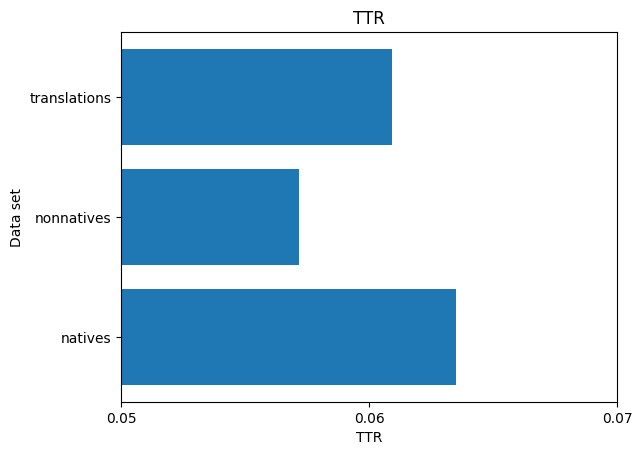

In [107]:
x = ['natives', 'nonnatives', 'translations']
y = ttr_lemmas
plt.barh(x, y)
plt.xticks(np.arange(0, 1, step=.01))
plt.xlim(0.05, 0.07)
plt.ylabel('Data set')
plt.xlabel('TTR')
plt.title("TTR")
# plt.grid()
plt.show()

In [108]:
# log TTR
log_ttr_lemmas = list(map(log_ttr, cut_lemmas))
log_ttr_lemmas

[0.7619817532106781, 0.7529352512155085, 0.7584201716085918]

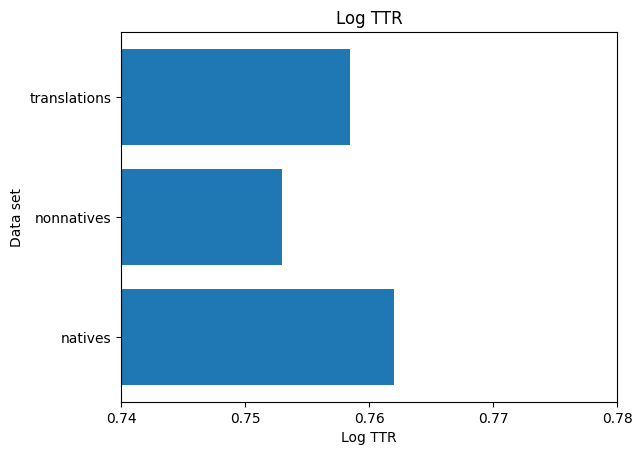

In [112]:
x = ['natives', 'nonnatives', 'translations']
y = log_ttr_lemmas
plt.barh(x, y)
plt.xticks(np.arange(0, 1, step=.01))
plt.xlim(0.74, 0.78)
plt.ylabel('Data set')
plt.xlabel('Log TTR')
plt.title("Log TTR")
# plt.grid()
plt.show()

In [599]:
# Moving Average TTR (window_length = 50 by default)
ma_ttr = list(map(lambda x: ld.mattr(x, 1000), lemmas))
ma_ttr

[0.4264038872618462, 0.4202583956163773, 0.421019149003176]

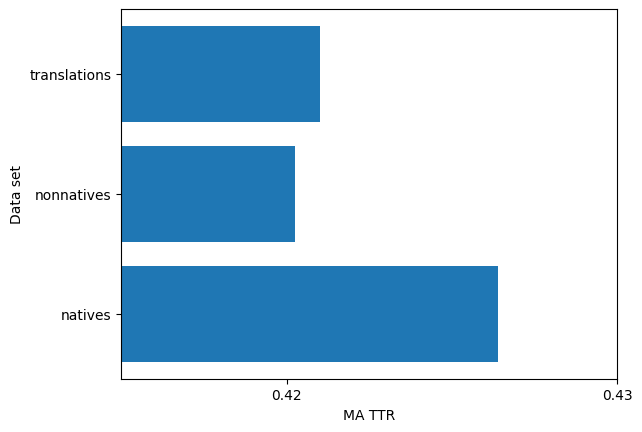

In [603]:
x = ['natives', 'nonnatives', 'translations']
y = ma_ttr
plt.barh(x, y)
plt.xticks(np.arange(0, 1, step=.01))
plt.xlim(0.415, 0.43)
plt.ylabel('Data set')
plt.xlabel('MA TTR')
# plt.grid()
plt.show()

In [602]:
%%time
# WARNING: SLOW!
ma_ttr_2000 = list(map(lambda x: ld.mattr(x, window_length=2000), lemmas))
ma_ttr_2000

CPU times: user 2min 7s, sys: 9.23 ms, total: 2min 7s
Wall time: 2min 8s


[0.3531964009012331, 0.345039368915889, 0.3460569551386511]

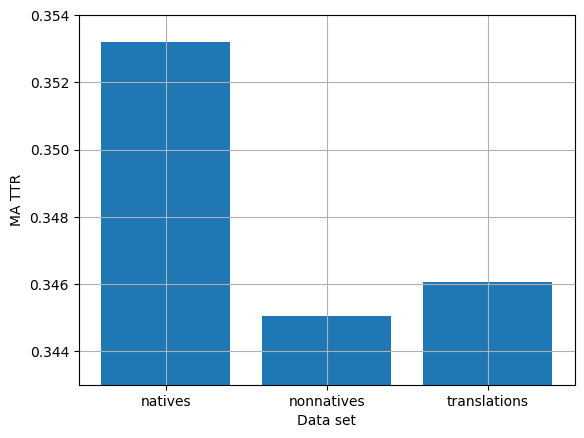

In [613]:
x = ['natives', 'nonnatives', 'translations']
y = ma_ttr_2000
plt.bar(x, y)
# plt.xticks(np.arange(0, 1, step=.01))
plt.ylim(0.343, 0.354)
plt.xlabel('Data set')
plt.ylabel('MA TTR')
plt.grid()
plt.show()

In [623]:
# MA TTR by country
ma_ttr_country = {c: ld.mattr(lem) for c, lem in lemmas_country.items() }

In [624]:
ma_ttr_country

{'United Kingdom': 0.7850633005936919,
 'Ireland': 0.7835920806872393,
 'Belgium': 0.7731886544866384,
 'Netherlands': 0.7816732218341681,
 'Spain': 0.7739557377048508,
 'Portugal': 0.7732528374787965,
 'Sweden': 0.7761572863629802,
 'Luxembourg': 0.7710685624012139,
 'Finland': 0.7836456595064233,
 'France': 0.7668983015011269,
 'Malta': 0.7797585342834994,
 'Cyprus': 0.7862634719870715,
 'Poland': 0.7760949974734335,
 'Hungary': 0.7846513914838422,
 'Estonia': 0.7844818178678015}

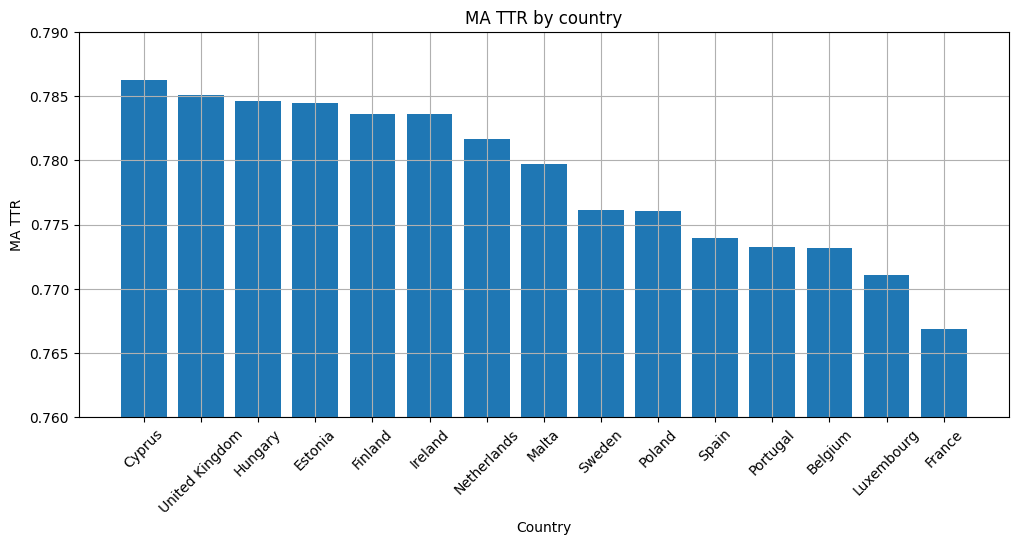

In [626]:
x, y = zip(*sorted(ma_ttr_country.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(12,5))
plt.bar(x, y)
# plt.xticks(np.arange(0, 1, step=.01))
plt.xticks(rotation=45)
plt.ylim(0.76, 0.79)
plt.xlabel('Country')
plt.ylabel('MA TTR')
plt.grid()
plt.title("MA TTR by country")
plt.show()

### <a id='toc8_1_2_'></a>[Lemmas clean](#toc0_)

In [115]:
lemmas_clean = [flatten_list(df.lemmas_clean.to_list()) for df in data_samples]

In [116]:
# min token length
min_lemmas_clean = min(map(len, lemmas_clean))
min_lemmas_clean

47768

In [117]:
list(map(ttr, lemmas_clean))

[0.12952185563557192, 0.05280385716971325, 0.03923802607939002]

In [118]:
list(map(log_ttr, lemmas_clean))

[0.8102947335976995, 0.7570377975658509, 0.7445171851021141]

In [119]:
# making lemma lists equal (min) length
cut_lemmas_clean = list(map(lambda x: x[:min_lemmas_clean + 1], lemmas_clean))

In [120]:
# TTR
ttr_lemmas_clean = list(map(ttr, cut_lemmas_clean))
ttr_lemmas_clean

[0.12952185563557192, 0.11273001318846951, 0.12545793296908037]

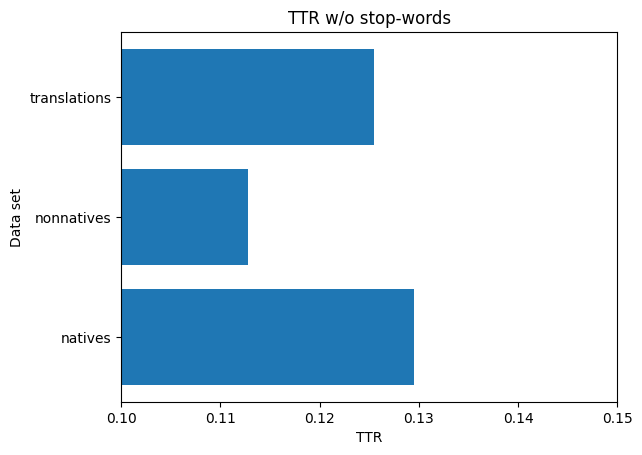

In [121]:
x = ['natives', 'nonnatives', 'translations']
y = ttr_lemmas_clean
plt.barh(x, y)
plt.xticks(np.arange(0, 1, step=.01))
plt.xlim(0.1, 0.15)
plt.ylabel('Data set')
plt.xlabel('TTR')
plt.title("TTR w/o stop-words")
# plt.grid()
plt.show()

In [124]:
# log TTR
log_ttr_clean = list(map(log_ttr, cut_lemmas_clean))
log_ttr_clean

[0.8102947335976995, 0.79740738762233, 0.8073362439937505]

In [125]:
# Moving Average TTR (window_length = 50 by default)
ma_ttr_clean = list(map(ld.mattr, lemmas_clean))
ma_ttr_clean

[0.9417188122130329, 0.9372178376083108, 0.937155182400068]

## <a id='toc8_2_'></a>[Unigrams](#toc0_)

In [ ]:
# word frequencies
word_freqs = [FreqDist(lem) for lem in lemmas_clean]

In [141]:
# natives
word_freqs[0].most_common(15)

[('european', 417),
 ('would', 380),
 ('mr', 357),
 ('president', 309),
 ('member', 305),
 ('state', 299),
 ('commission', 284),
 ('report', 268),
 ('must', 267),
 ('person', 249),
 ('union', 238),
 ('also', 231),
 ('make', 231),
 ('take', 225),
 ('parliament', 225)]

<Axes: title={'center': 'natives'}, xlabel='Samples', ylabel='Counts'>

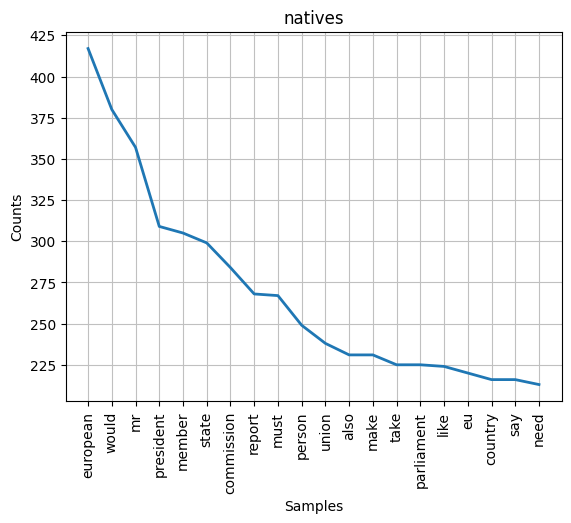

In [146]:
word_freqs[0].plot(20, title='natives')

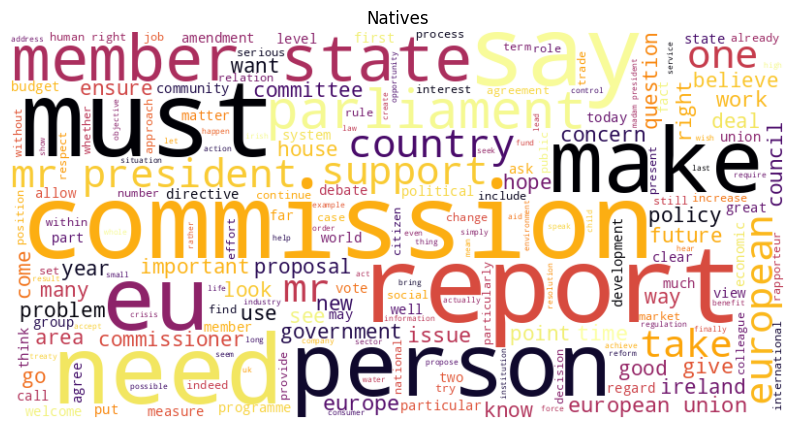

In [151]:
wordcloud = WordCloud(background_color='white',
                      colormap = 'inferno_r',
                      width=800, height=400,
                      random_state=21,
                      max_font_size=110).generate(' '.join(lemmas_clean[0]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Natives")
plt.show()

In [142]:
# nonnatives
word_freqs[1].most_common(15)

[('european', 1982),
 ('commission', 1792),
 ('member', 1598),
 ('state', 1418),
 ('mr', 1159),
 ('also', 1156),
 ('eu', 1114),
 ('president', 1026),
 ('would', 1007),
 ('parliament', 981),
 ('union', 924),
 ('right', 910),
 ('make', 899),
 ('council', 897),
 ('need', 866)]

<Axes: title={'center': 'nonnatives'}, xlabel='Samples', ylabel='Counts'>

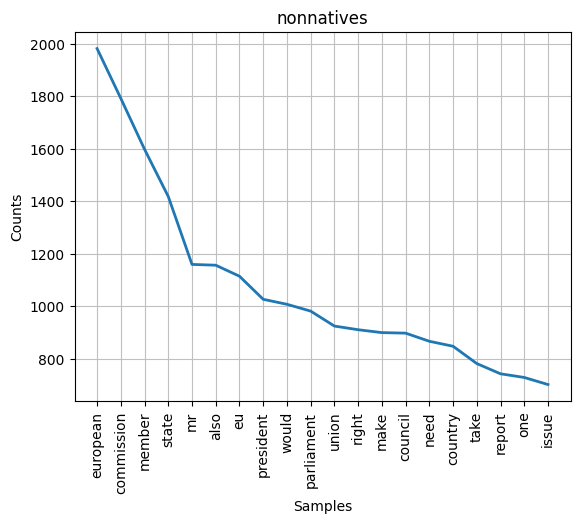

In [145]:
word_freqs[1].plot(20, title='nonnatives')

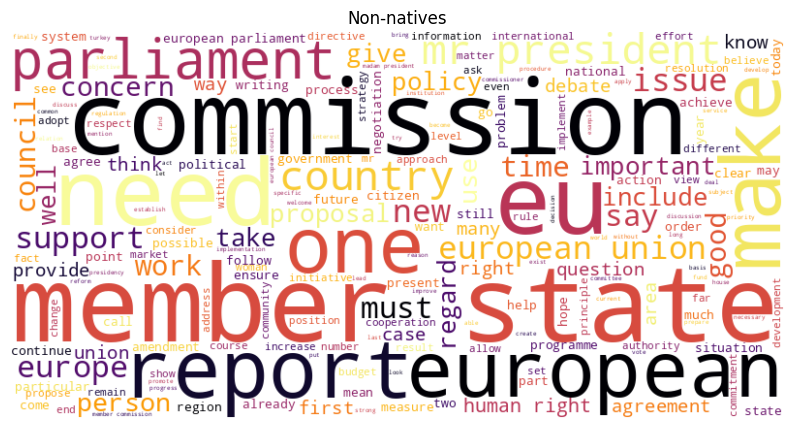

In [150]:
wordcloud = WordCloud(background_color='white',
                      colormap = 'inferno_r',
                      width=800, height=400,
                      random_state=21,
                      max_font_size=110).generate(' '.join(lemmas_clean[1]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Non-natives")
plt.show()

In [143]:
# translations
word_freqs[2].most_common(15)

[('european', 4755),
 ('state', 2512),
 ('also', 2224),
 ('union', 2208),
 ('would', 2202),
 ('member', 2194),
 ('must', 2184),
 ('country', 2028),
 ('commission', 1918),
 ('mr', 1884),
 ('make', 1650),
 ('eu', 1648),
 ('parliament', 1592),
 ('president', 1580),
 ('report', 1476)]

<Axes: title={'center': 'translations'}, xlabel='Samples', ylabel='Counts'>

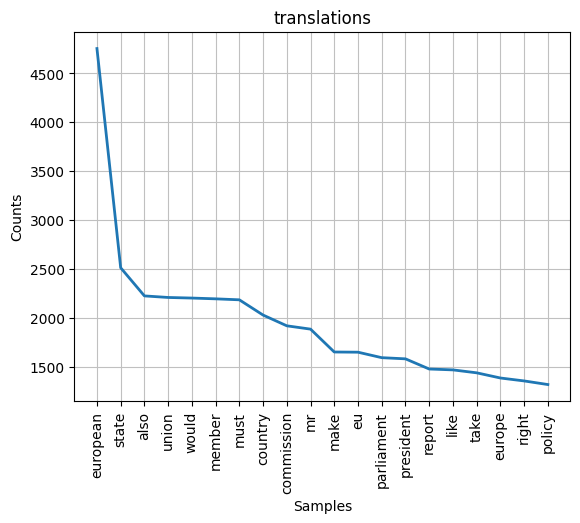

In [144]:
word_freqs[2].plot(20, title='translations')

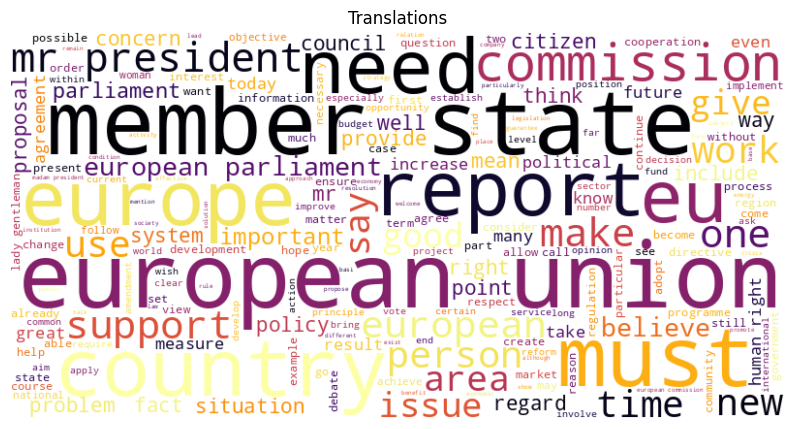

In [149]:
wordcloud = WordCloud(background_color='white',
                      colormap = 'inferno_r',
                      width=800, height=400,
                      random_state=21,
                      max_font_size=110).generate(' '.join(lemmas_clean[2]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Translations")
plt.show()

### <a id='toc8_2_1_'></a>[Adding custom stop-words](#toc0_)

In [135]:
my_stop_list = nltk_stopwords_en + ['mr', 'europe', 'european', 'union', 'eu', 'member', 'state', 'country', 'parliament', 'president', 'commission', 'council']
my_stop_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [136]:
# filtering out additional custom stop-words
lemmas_cleaner = list(map(lambda x: filter_stop_words(x, my_stop_list), lemmas_clean))

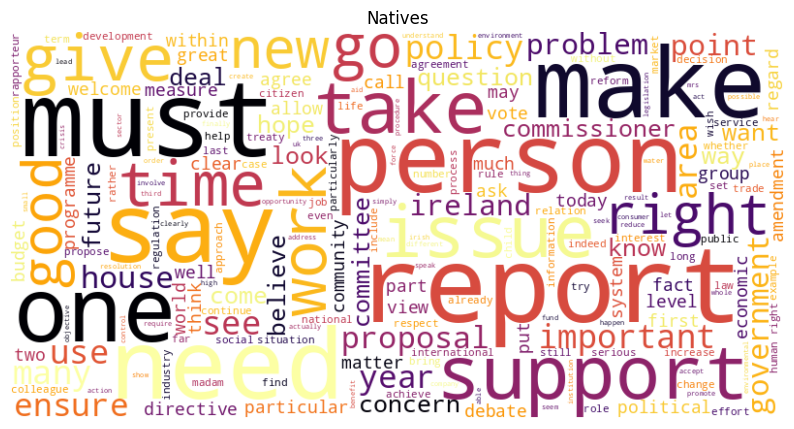

In [153]:
wordcloud = WordCloud(background_color='white',
                      colormap = 'inferno_r',
                      width=800, height=400,
                      random_state=21,
                      max_font_size=110).generate(' '.join(lemmas_cleaner[0]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Natives")
plt.show()

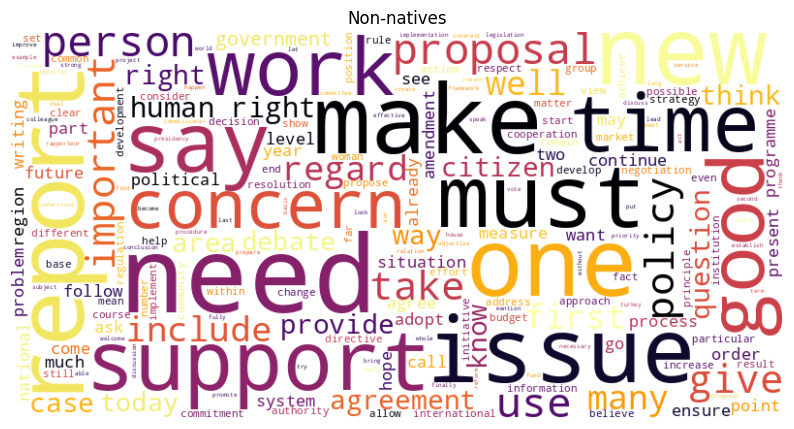

In [154]:
wordcloud = WordCloud(background_color='white',
                      colormap = 'inferno_r',
                      width=800, height=400,
                      random_state=21,
                      max_font_size=110).generate(' '.join(lemmas_cleaner[1]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Non-natives")
plt.show()

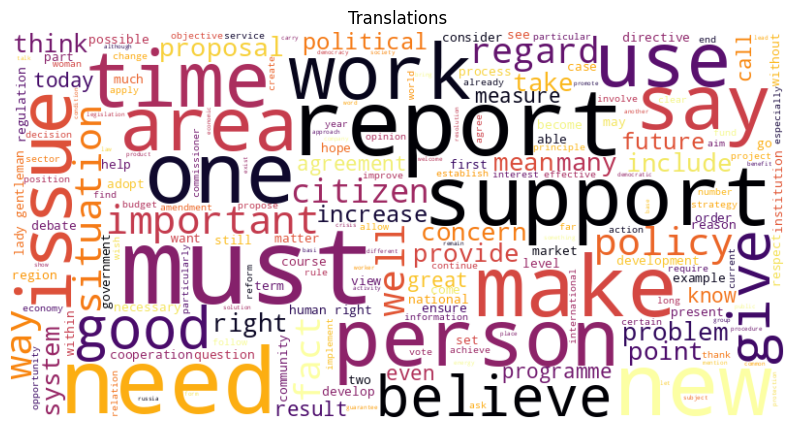

In [152]:
wordcloud = WordCloud(background_color='white',
                      colormap = 'inferno_r',
                      width=800, height=400,
                      random_state=21,
                      max_font_size=110).generate(' '.join(lemmas_cleaner[2]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Translations")
plt.show()

## <a id='toc8_3_'></a>[Bigrams](#toc0_)

### <a id='toc8_3_1_'></a>[All bigrams](#toc0_)

In [272]:
bigrams = [flatten_list(df.bigrams.to_list()) for df in data_samples]

In [ ]:
bigrams_freqs = [Counter(big) for big in bigrams]

### <a id='toc8_3_2_'></a>[Bigrams w/o stops](#toc0_)

In [155]:
bigrams_clean = [nltk.bigrams(lem) for lem in lemmas_clean]

In [156]:
bigrams_freqs_clean = [Counter(big) for big in bigrams_clean]

In [157]:
# natives
bigrams_freqs_clean[0].most_common(15)

[(('member', 'state'), 194),
 (('mr', 'president'), 186),
 (('european', 'union'), 164),
 (('would', 'like'), 101),
 (('human', 'right'), 62),
 (('madam', 'president'), 47),
 (('take', 'place'), 33),
 (('european', 'parliament'), 33),
 (('president', 'office'), 33),
 (('like', 'thank'), 24),
 (('would', 'also'), 22),
 (('president', 'would'), 21),
 (('last', 'year'), 20),
 (('long', 'term'), 19),
 (('european', 'commission'), 18)]

In [179]:
# convert absolute to relative frequency counts
def abs2rel_freq(y):
    s = sum(y)
    return list(map(lambda x: x / s * 100., y))

In [ ]:
# Counter data to lists of strings and relative frequencies
def get_bigram_data(bigrams, n_common=10):
    x, y = zip(*bigrams.most_common(n_common))
    # merging words
    x = [" ".join(t) for t in x]
    # abs to rel freq
    y = abs2rel_freq(y) 
    return x, y

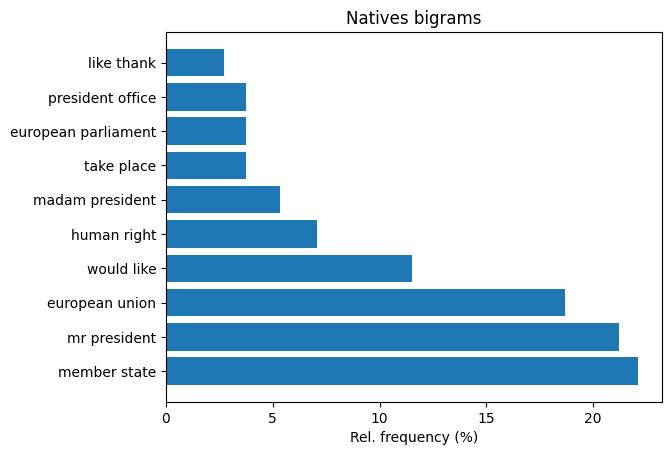

In [191]:
x, y = get_bigram_data(bigrams_freqs_clean[0])
plt.barh(x, y)
plt.title("Natives bigrams")
plt.xlabel("Rel. frequency (%)")
plt.show()


In [158]:
# nonnatives
bigrams_freqs_clean[1].most_common(15)

[(('member', 'state'), 1075),
 (('mr', 'president'), 590),
 (('european', 'union'), 574),
 (('would', 'like'), 357),
 (('human', 'right'), 336),
 (('european', 'parliament'), 287),
 (('madam', 'president'), 148),
 (('european', 'council'), 141),
 (('member', 'commission'), 138),
 (('like', 'thank'), 96),
 (('fundamental', 'right'), 94),
 (('honourable', 'member'), 94),
 (('take', 'account'), 91),
 (('commission', 'mr'), 82),
 (('third', 'country'), 77)]

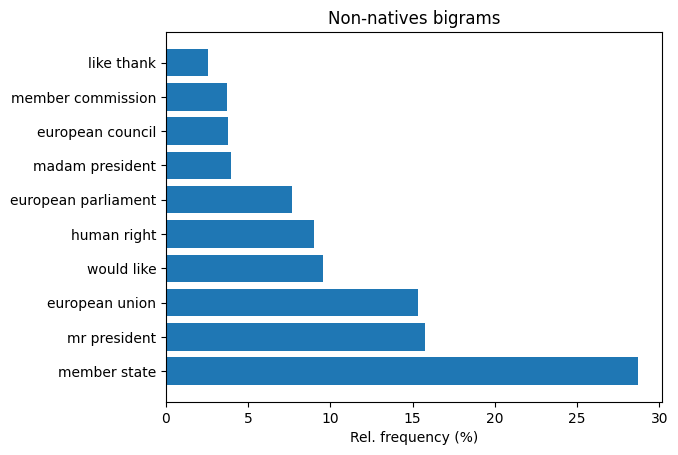

In [190]:
x, y = get_bigram_data(bigrams_freqs_clean[1])
plt.barh(x, y)
plt.title("Non-natives bigrams")
plt.xlabel("Rel. frequency (%)")
plt.show()

In [159]:
# translations
bigrams_freqs_clean[2].most_common(15)

[(('european', 'union'), 1714),
 (('member', 'state'), 1665),
 (('mr', 'president'), 1055),
 (('would', 'like'), 789),
 (('european', 'parliament'), 668),
 (('human', 'right'), 437),
 (('lady', 'gentleman'), 404),
 (('european', 'commission'), 257),
 (('madam', 'president'), 227),
 (('new', 'member'), 218),
 (('vote', 'favour'), 194),
 (('like', 'thank'), 178),
 (('take', 'place'), 171),
 (('internal', 'market'), 165),
 (('take', 'account'), 162)]

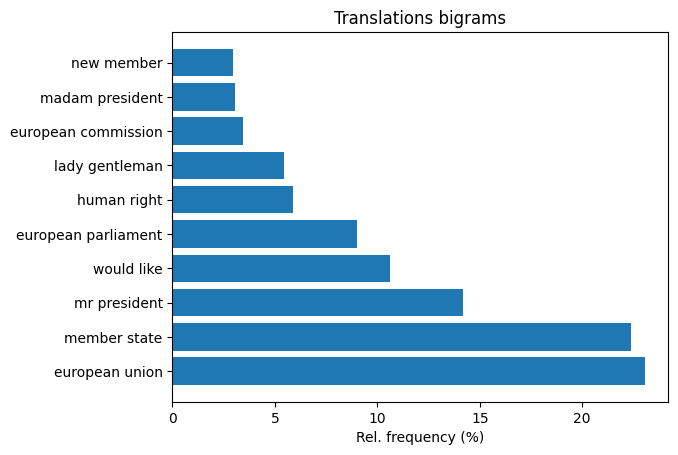

In [189]:
x, y = get_bigram_data(bigrams_freqs_clean[2])
plt.barh(x, y)
plt.title("Translations bigrams")
plt.xlabel("Rel. frequency (%)")
plt.show()

## <a id='toc8_4_'></a>[POS](#toc0_)

```ADJ: adjective
ADP: adposition
ADV: adverb
AUX: auxiliary
CCONJ: coordinating conjunction
DET: determiner
INTJ: interjection
NOUN: noun
NUM: numeral
PART: particle
PRON: pronoun
PROPN: proper noun
PUNCT: punctuation
SCONJ: subordinating conjunction
SYM: symbol
VERB: verb
X: other
```

### <a id='toc8_4_1_'></a>[POS Unigrams](#toc0_)

Clean POS tokens: w/o punctuation, numbers etc. 

In [247]:
# pos = [natives_pos, nonnatives_pos, translations_pos]
pos_clean = [flatten_list(df.pos_clean.to_list()) for df in data_samples]

In [211]:
def calc_pos_rel_freq(pos_list: list) -> list[tuple]:
    freq_list = Counter(pos_list)
    res = [(f[0], f[1] / len(pos_list) * 100.) for f in sorted(freq_list.items(), key=lambda x: x[1], reverse=True)]
    return res

In [248]:
pos_rel_freqs = [calc_pos_rel_freq(p) for p in pos_clean]

In [213]:
natives_pos_rel_freq = pos_rel_freqs[0]
natives_pos_rel_freq

[('NOUN', 19.85934256591381),
 ('ADP', 12.333860024165814),
 ('VERB', 11.697700116698165),
 ('DET', 11.245365637037725),
 ('ADJ', 8.481787857194494),
 ('PRON', 8.447707862151583),
 ('AUX', 7.188813499808945),
 ('PROPN', 5.917526411996158),
 ('ADV', 4.687548409083868),
 ('PART', 3.629003108508639),
 ('CCONJ', 3.5019776724396117),
 ('SCONJ', 2.973221385713253),
 ('INTJ', 0.036145449287934645)]

In [214]:
nonnatives_pos_rel_freq = pos_rel_freqs[1]
nonnatives_pos_rel_freq

[('NOUN', 20.89059706325407),
 ('ADP', 12.721206233897874),
 ('DET', 12.107389731244105),
 ('VERB', 11.007306668919204),
 ('ADJ', 9.234559558502625),
 ('PRON', 6.883754980219904),
 ('PROPN', 6.601906209964663),
 ('AUX', 6.524193661922259),
 ('ADV', 4.547310329292844),
 ('CCONJ', 3.5592910137827145),
 ('PART', 3.277442243527474),
 ('SCONJ', 2.6067491658571607),
 ('INTJ', 0.03829313961509763)]

In [215]:
translations_pos_rel_freq = pos_rel_freqs[2]
translations_pos_rel_freq

[('NOUN', 21.05155867279497),
 ('ADP', 12.719579045271107),
 ('DET', 11.87152217051597),
 ('VERB', 10.985561533095717),
 ('ADJ', 9.349966396244023),
 ('PRON', 6.934955232152583),
 ('AUX', 6.801177246275716),
 ('PROPN', 5.665816220899306),
 ('ADV', 4.644644262039222),
 ('CCONJ', 3.705650208789214),
 ('PART', 3.37534599127895),
 ('SCONJ', 2.8711303921287583),
 ('INTJ', 0.02309262851445917)]

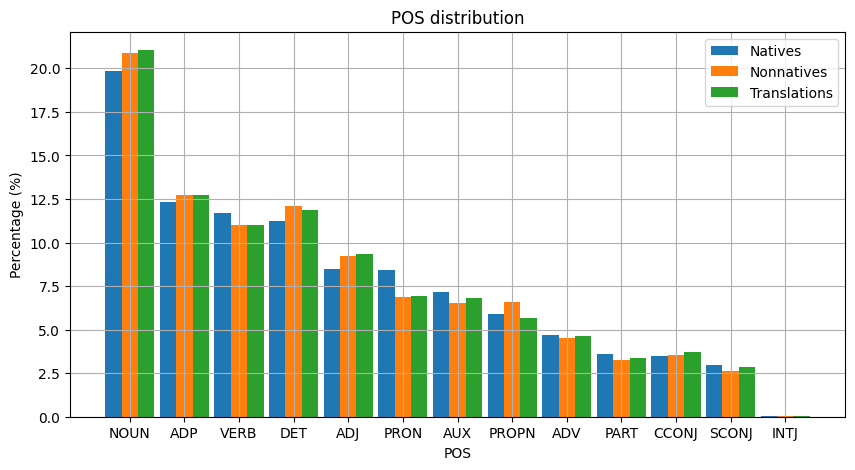

In [216]:
x, y_nat = zip(*natives_pos_rel_freq)
y_non = [dict(nonnatives_pos_rel_freq)[i] for i in x]
y_tra = [dict(translations_pos_rel_freq)[i] for i in x]
x_axis = np.arange(len(x)) 

plt.figure(figsize=(10,5))
plt.bar(x_axis - 0.3, y_nat, width=0.3, label='Natives')
plt.bar(x_axis, y_non, width=0.3, label='Nonnatives')
plt.bar(x_axis + 0.3, y_tra, width=0.3, label='Translations')
plt.xticks(x_axis, x)
plt.xlabel('POS')
plt.ylabel('Percentage (%)')
plt.title('POS distribution')
plt.legend()
plt.grid()
plt.show()

#### <a id='toc8_4_1_1_'></a>[Function words](#toc0_)

Calculating function words POS relative frequencies.

In [205]:
# Function words: https://universaldependencies.org/u/pos/
closed_class_words = ('ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON', 'SCONJ')

In [218]:
# function words frequency / частота служебных слов
def sum_closed_class_words_freq(pos_rel_freq_list: list) -> float:
    return sum(f[1] for f in pos_rel_freq_list if f[0] in closed_class_words)

In [219]:
pos_closed_class_freq = [sum_closed_class_words_freq(f) for f in pos_rel_freqs]

In [220]:
# natives
pos_closed_class_freq[0]

49.31994918982557

In [221]:
# nonnatives
pos_closed_class_freq[1]

47.68002703045149

In [222]:
# translations
pos_closed_class_freq[2]

48.27936028641229

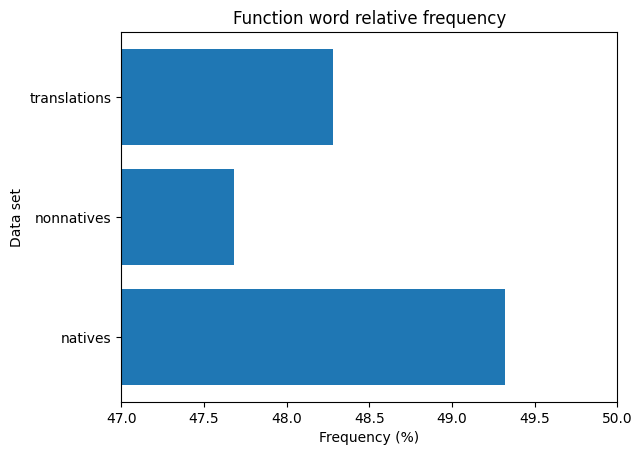

In [228]:
x = ['natives', 'nonnatives', 'translations']
y = pos_closed_class_freq
plt.barh(x, y)
# plt.xticks(np.arange(0, 1, step=.01))
plt.xlim(47, 50)
plt.ylabel('Data set')
plt.xlabel('Frequency (%)')
plt.title("Function word relative frequency")
# plt.grid()
plt.show()

### <a id='toc8_4_2_'></a>[POS bigrams](#toc0_)

In [249]:
pos_clean_bigrams = [list(nltk.bigrams(p)) for p in pos_clean]

In [250]:
pos_bigram_abs_freqs = [Counter(p) for p in pos_clean_bigrams]

In [ ]:
# def pos_bigrams_rel_freq(pos_list: list) -> list[tuple]:
#     pos_bigrams_list = nltk.bigrams(pos_list)
#     freq_list = Counter(pos_bigrams_list)
#     res = [(f[0], f[1] / (len(pos_list) - 1) * 100.) for f in sorted(freq_list.items(), key=lambda x: x[1], reverse=True)]
#     return res

In [240]:
# natives
pos_bigram_abs_freqs[0].most_common(15)
# pos_bigrams_rel_freq(pos[0])[:15]

[(('NOUN', 'ADP'), 6141),
 (('DET', 'NOUN'), 5821),
 (('ADP', 'DET'), 5247),
 (('ADJ', 'NOUN'), 4974),
 (('PRON', 'AUX'), 3050),
 (('DET', 'ADJ'), 2920),
 (('AUX', 'VERB'), 2823),
 (('PART', 'VERB'), 2542),
 (('VERB', 'ADP'), 2526),
 (('ADP', 'NOUN'), 2423),
 (('VERB', 'DET'), 2394),
 (('NOUN', 'PRON'), 2303),
 (('NOUN', 'NOUN'), 2178),
 (('PRON', 'VERB'), 2176),
 (('NOUN', 'CCONJ'), 1838)]

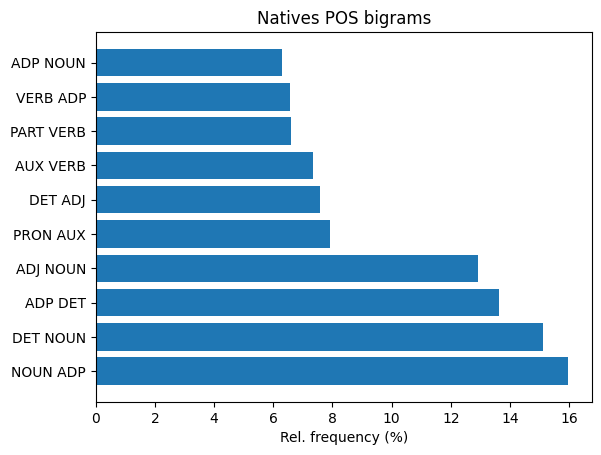

In [244]:
x, y = get_bigram_data(pos_bigram_abs_freqs[0])
plt.barh(x, y)
plt.title("Natives POS bigrams")
plt.xlabel("Rel. frequency (%)")
plt.show()


In [243]:
# nonnatives
pos_bigram_abs_freqs[1].most_common(15)
# pos_bigrams_rel_freq(pos[1])[:15]

[(('NOUN', 'ADP'), 25224),
 (('DET', 'NOUN'), 22005),
 (('ADP', 'DET'), 20884),
 (('ADJ', 'NOUN'), 20186),
 (('DET', 'ADJ'), 12080),
 (('PRON', 'AUX'), 9545),
 (('ADP', 'NOUN'), 9365),
 (('VERB', 'DET'), 9201),
 (('AUX', 'VERB'), 9158),
 (('NOUN', 'NOUN'), 8962),
 (('VERB', 'ADP'), 8666),
 (('PART', 'VERB'), 8196),
 (('NOUN', 'PRON'), 7073),
 (('NOUN', 'CCONJ'), 6840),
 (('PRON', 'VERB'), 6200)]

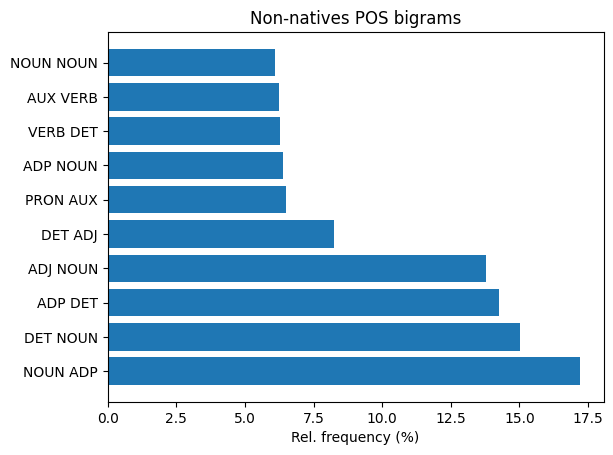

In [245]:
x, y = get_bigram_data(pos_bigram_abs_freqs[1])
plt.barh(x, y)
plt.title("Non-natives POS bigrams")
plt.xlabel("Rel. frequency (%)")
plt.show()


In [242]:
# translations
pos_bigram_abs_freqs[2].most_common(15)
# pos_bigrams_rel_freq(pos[2])[:15]

[(('NOUN', 'ADP'), 44182),
 (('DET', 'NOUN'), 40062),
 (('ADP', 'DET'), 36331),
 (('ADJ', 'NOUN'), 35223),
 (('DET', 'ADJ'), 21528),
 (('ADP', 'NOUN'), 17629),
 (('PRON', 'AUX'), 17172),
 (('AUX', 'VERB'), 17148),
 (('VERB', 'ADP'), 15928),
 (('VERB', 'DET'), 15495),
 (('PART', 'VERB'), 14194),
 (('NOUN', 'NOUN'), 14192),
 (('NOUN', 'PRON'), 13420),
 (('NOUN', 'CCONJ'), 13293),
 (('NOUN', 'AUX'), 11225)]

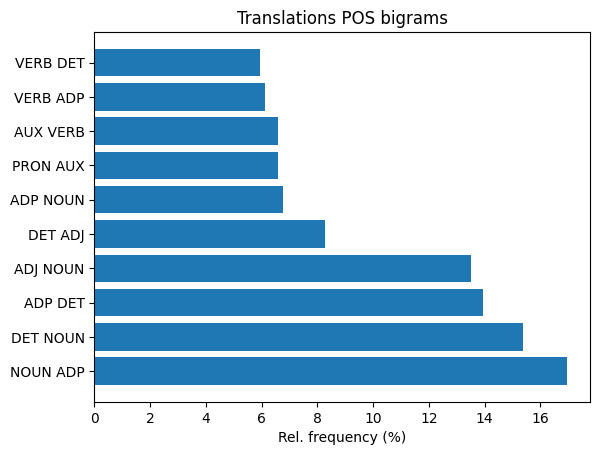

In [246]:
x, y = get_bigram_data(pos_bigram_abs_freqs[2])
plt.barh(x, y)
plt.title("Translations POS bigrams")
plt.xlabel("Rel. frequency (%)")
plt.show()


### <a id='toc8_4_3_'></a>[AN vs. NN frequencies](#toc0_)

In [453]:
pos_bigrams = [flatten_list(df.pos_bigrams.to_list()) for df in data_samples]

In [454]:
pos_bigrams[0][:5]

[('PRON', 'ADV'),
 ('ADV', 'VERB'),
 ('VERB', 'PROPN'),
 ('PROPN', 'PART'),
 ('PART', 'NOUN')]

In [455]:
# creating lists of countries (same length as the list of bigrams)
countries = []
for i in range(3):
    cntrs = []
    df = data_samples[i]
    for _, row in df.iterrows():
        c = row.state if row.state else "unk"
        cntrs += [c] * row.n_bigrams
    countries.append(cntrs)

In [456]:
len(countries[0])

103192

In [457]:
# combining bigrams with their respective POS to disambiguate
bigrams_pos_bigrams = [[bi + pbi + (ctr, ) for (bi, pbi, ctr) in zip(bigrams[i], pos_bigrams[i], countries[i])] for i in range(3)]

In [458]:
bigrams_pos_bigrams[0][:5]

[('we', 'therefore', 'PRON', 'ADV', 'United Kingdom'),
 ('therefore', 'need', 'ADV', 'VERB', 'United Kingdom'),
 ('need', 'Russia', 'VERB', 'PROPN', 'United Kingdom'),
 ('Russia', '"s"', 'PROPN', 'PART', 'United Kingdom'),
 ('"s"', 'help', 'PART', 'NOUN', 'United Kingdom')]

In [459]:
bigrams_pos_bigrams_freqs = [Counter(b) for b in bigrams_pos_bigrams]

In [460]:
# most common
bigrams_pos_bigrams_freqs[0].most_common(10)

[(('of', 'the', 'ADP', 'DET', 'United Kingdom'), 480),
 (('of', 'the', 'ADP', 'DET', 'Ireland'), 463),
 (('in', 'the', 'ADP', 'DET', 'United Kingdom'), 309),
 (('in', 'the', 'ADP', 'DET', 'Ireland'), 296),
 (('it', 'be', 'PRON', 'AUX', 'Ireland'), 255),
 (('it', 'be', 'PRON', 'AUX', 'United Kingdom'), 216),
 (('to', 'the', 'ADP', 'DET', 'Ireland'), 208),
 (('to', 'the', 'ADP', 'DET', 'United Kingdom'), 181),
 (('on', 'the', 'ADP', 'DET', 'Ireland'), 159),
 (('the', 'European', 'DET', 'ADJ', 'Ireland'), 155)]

In [461]:
# least commmon
list(reversed(bigrams_pos_bigrams_freqs[0].most_common()))[:10]

[(('use', 'it', 'VERB', 'PRON', 'Ireland'), 1),
 (('it', 'happen', 'PRON', 'VERB', 'Ireland'), 1),
 (('other', ',', 'NOUN', 'PUNCT', 'Ireland'), 1),
 (('politics', 'than', 'NOUN', 'ADP', 'Ireland'), 1),
 (('European', 'politics', 'ADJ', 'NOUN', 'Ireland'), 1),
 (('influential', 'in', 'ADJ', 'ADP', 'Ireland'), 1),
 (('more', 'influential', 'ADV', 'ADJ', 'Ireland'), 1),
 (('damaging', 'or', 'ADJ', 'CCONJ', 'Ireland'), 1),
 (('more', 'damaging', 'ADV', 'ADJ', 'Ireland'), 1),
 (('dramatic', ',', 'ADJ', 'PUNCT', 'Ireland'), 1)]

In [462]:
# converting to a data frame
bigrams_pos_bigrams_df = []
for i in range(3):
    temp =list(zip(*bigrams_pos_bigrams_freqs[i]))
    bigrams_pos_bigrams_df.append(pd.DataFrame(
        {'lemma1': temp[0], 
         'lemma2': temp[1], 
         'pos1': temp[2], 
         'pos2': temp[3], 
         'count': bigrams_pos_bigrams_freqs[i].values(),
         'country': temp[4]
        }))

In [463]:
bigrams_pos_bigrams_df[0]

lemma1     lemma2   pos1   pos2  count         country
0             we  therefore   PRON    ADV      4  United Kingdom
1      therefore       need    ADV   VERB      1  United Kingdom
2           need     Russia   VERB  PROPN      2  United Kingdom
3         Russia        "s"  PROPN   PART      3  United Kingdom
4            "s"       help   PART   NOUN      2  United Kingdom
...          ...        ...    ...    ...    ...             ...
54551   European   politics    ADJ   NOUN      1         Ireland
54552   politics       than   NOUN    ADP      1         Ireland
54553      other          ,   NOUN  PUNCT      1         Ireland
54554         it     happen   PRON   VERB      1         Ireland
54555        use         it   VERB   PRON      1         Ireland

[54556 rows x 6 columns]

In [628]:
# minimum count for bigrams (lower threshold) to calculate statistics
def calc_draw_an_nn(THRESHOLD = 0):
    # bigram type count by country
    an_count = {}
    nn_count = {}
    all_count = {}

    # counting summary bigrams statistics by country
    for df in bigrams_pos_bigrams_df:
        # df = bigrams_pos_bigrams_df[0]
        df_min = df[df['count'] > THRESHOLD]
        for c in df_min.country.unique():
            all_count[c] = df_min[df_min['country'] == c]['count'].sum()

        an_df = df_min[(df_min['pos1'] == 'ADJ') & (df_min['pos2'] == 'NOUN')]
        for c in an_df.country.unique():
            an_count[c] = an_df[an_df['country'] == c]['count'].sum()

        nn_df = df_min[(df_min['pos1'] == 'NOUN') & (df_min['pos2'] == 'NOUN')]
        for c in nn_df.country.unique():
            nn_count[c] = nn_df[nn_df['country'] == c]['count'].sum()

    # calculating relative NN and AN frequencies
    nn_rel_count = {}
    an_rel_count = {}
    for c in nn_count.keys():
        nn_rel_count[c] = nn_count[c] / (nn_count[c] + an_count[c]) * 100.
        an_rel_count[c] = 100. - nn_rel_count[c]

    # drawing NN chart
    x, y = zip(*sorted(nn_rel_count.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.xticks(rotation=45)
    plt.yticks(np.arange(0, 40, step=5))
    plt.xlabel('Country')
    plt.ylabel('NN bigram percentage (%)')
    plt.title(f"NN / (NN + AN) (threshold {THRESHOLD})")
    plt.grid()
    plt.show

    # drawing AN chart
    x, y = zip(*sorted(an_rel_count.items(), key=lambda x: x[1], reverse=False))
    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.xticks(rotation=45)
    # plt.yticks(np.arange(0, 40, step=5))
    plt.xlabel('Country')
    plt.ylabel('AN bigram percentage (%)')
    plt.title(f"AN / (NN + AN) (threshold {THRESHOLD})")
    plt.grid()
    plt.show

    ## AN / ALL, NN / ALL
    nn_rel_count_all = {}
    an_rel_count_all = {}
    for c in nn_count.keys():
        nn_rel_count_all[c] = nn_count[c] / all_count[c] * 100.
        an_rel_count_all[c] = an_count[c] / all_count[c] * 100.

    x, y = zip(*sorted(nn_rel_count_all.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.xticks(rotation=45)
    # plt.yticks(np.arange(0, 40, step=5))
    plt.xlabel('Country')
    plt.ylabel('NN bigram percentage (%)')
    plt.title(f"NN / ALL (threshold {THRESHOLD})")
    plt.grid()
    plt.show

    x, y = zip(*sorted(an_rel_count_all.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.xticks(rotation=45)
    # plt.yticks(np.arange(0, 40, step=5))
    plt.xlabel('Country')
    plt.ylabel('AN bigram percentage (%)')
    plt.title(f"AN / ALL (threshold {THRESHOLD})")
    plt.grid()
    plt.show

    # NN / AN
    nn_an_rel_count = {}
    for c in nn_count.keys():
        nn_an_rel_count[c] = nn_count[c] / an_count[c] * 100.

    x, y = zip(*sorted(nn_an_rel_count.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.xticks(rotation=45)
    # plt.yticks(np.arange(0, 40, step=5))
    plt.xlabel('Country')
    plt.ylabel('NN bigram percentage (%)')
    plt.title(f"NN / AN (threshold {THRESHOLD})")
    plt.grid()
    plt.show


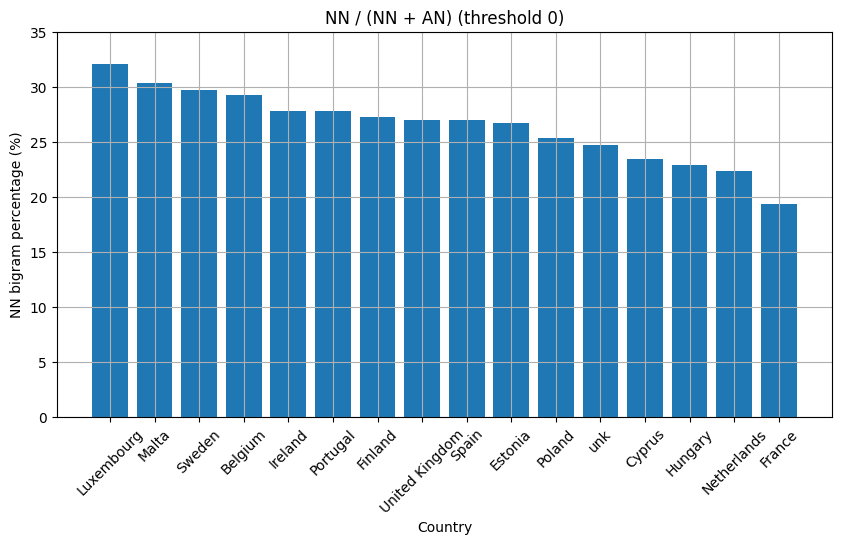

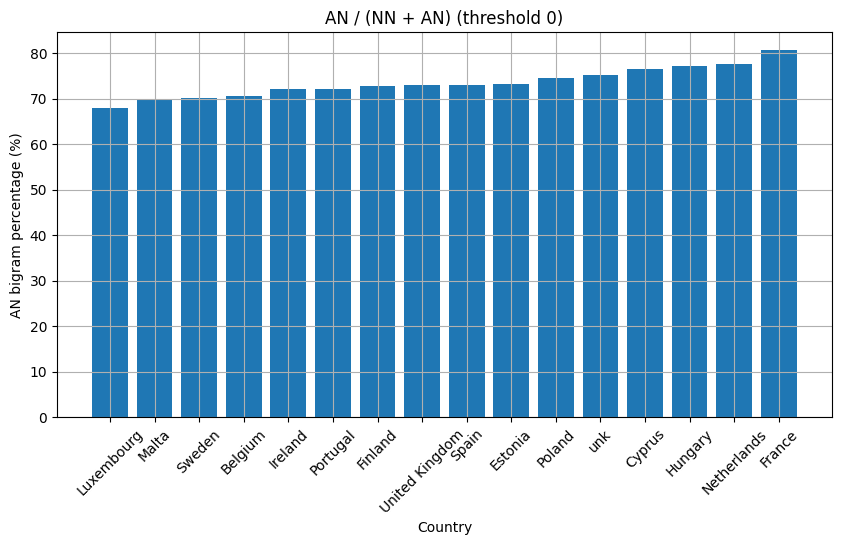

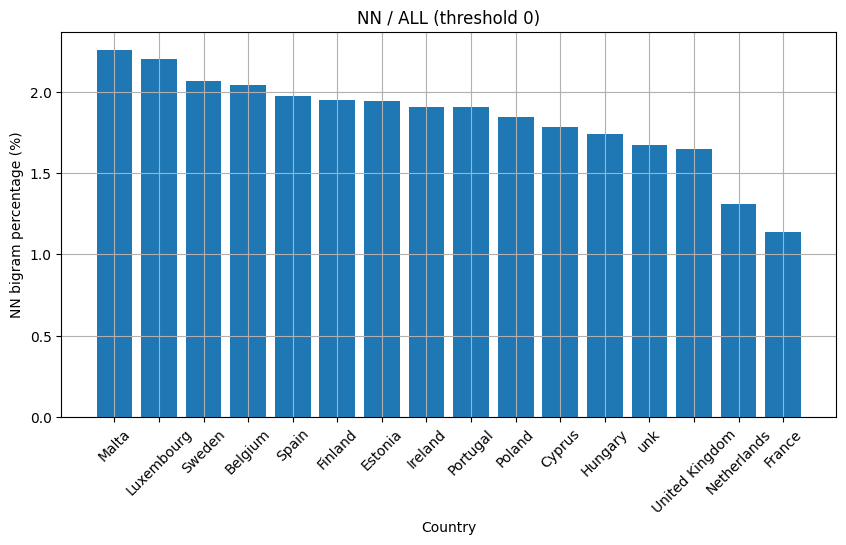

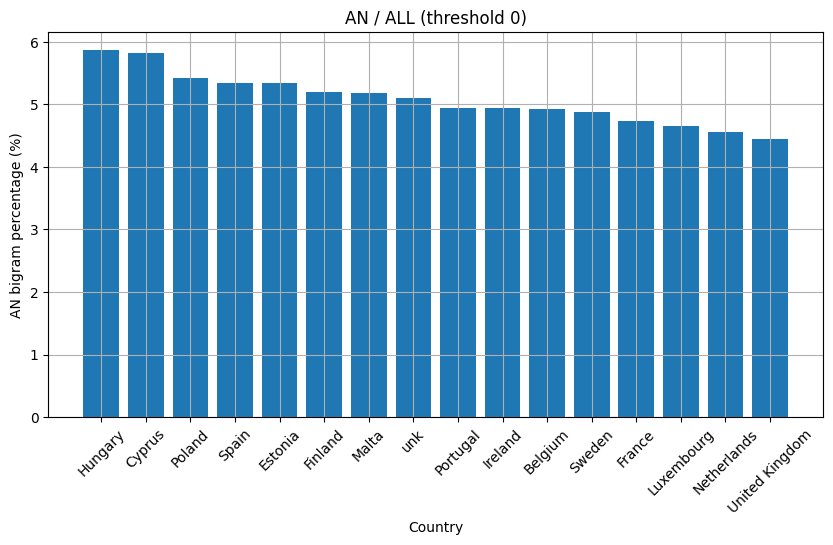

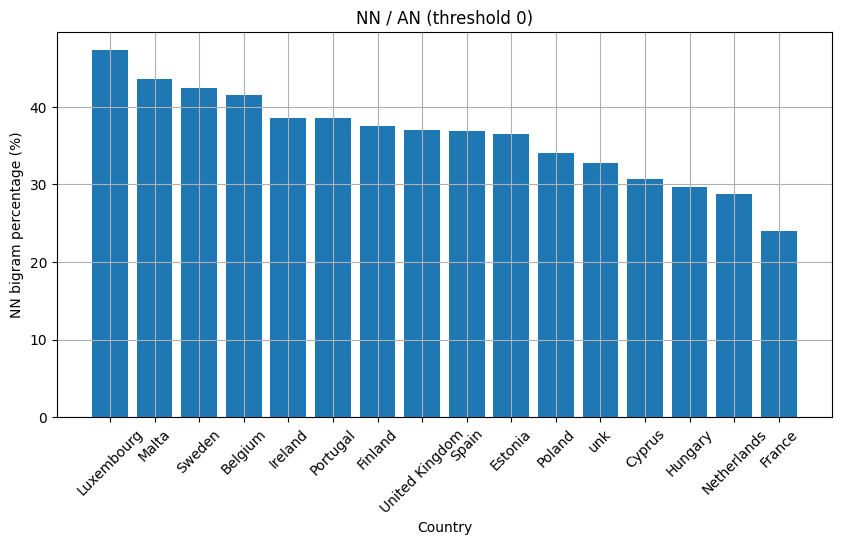

In [629]:
# threshold 0
calc_draw_an_nn(0)

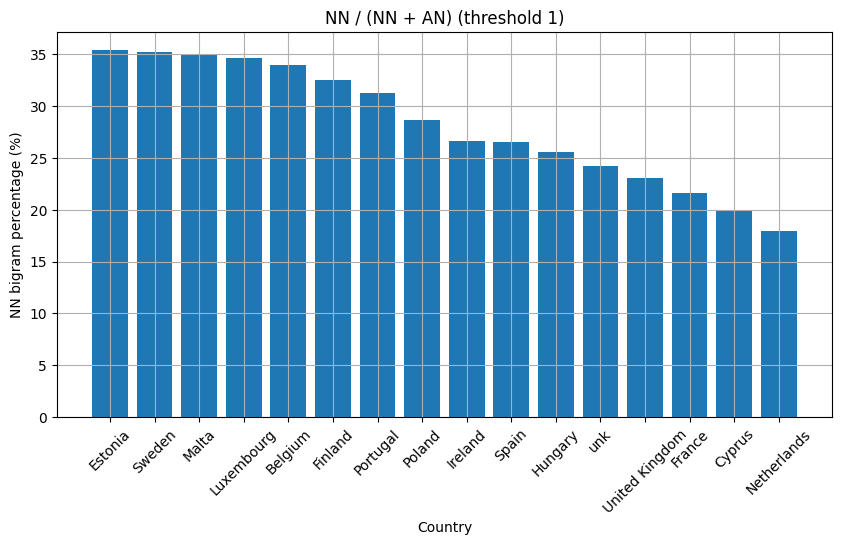

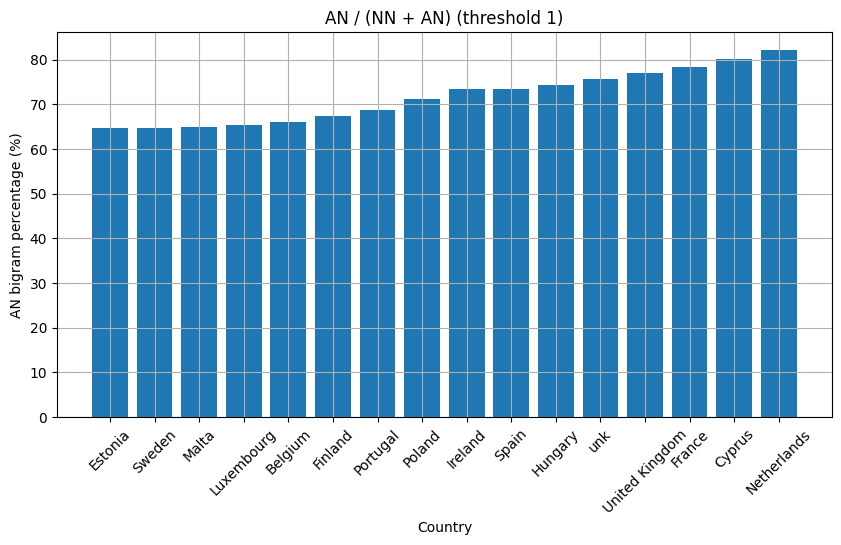

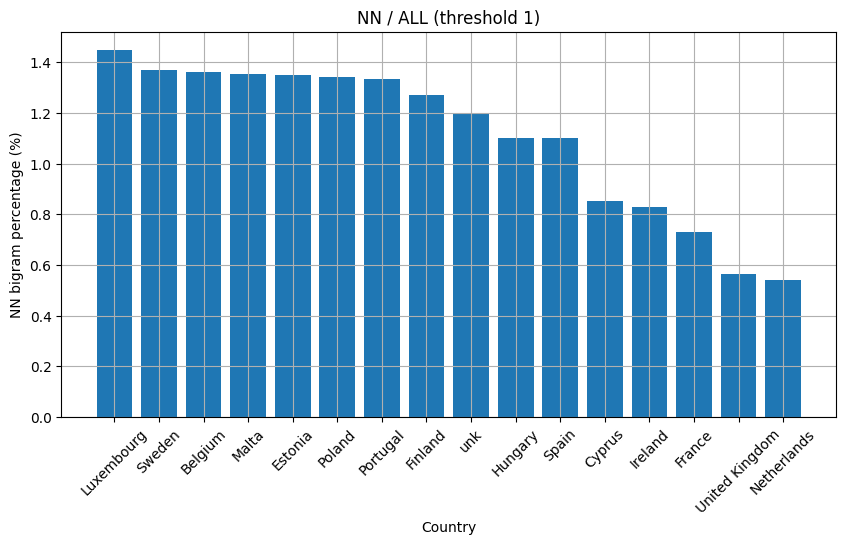

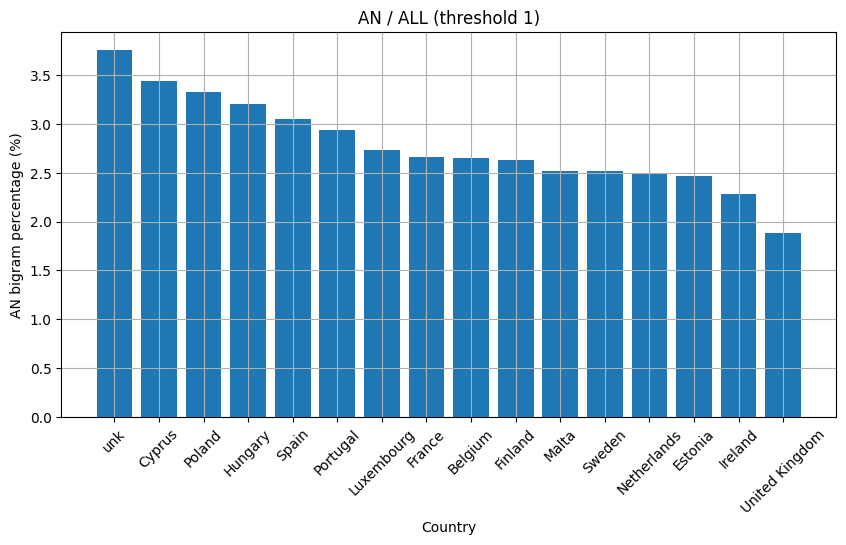

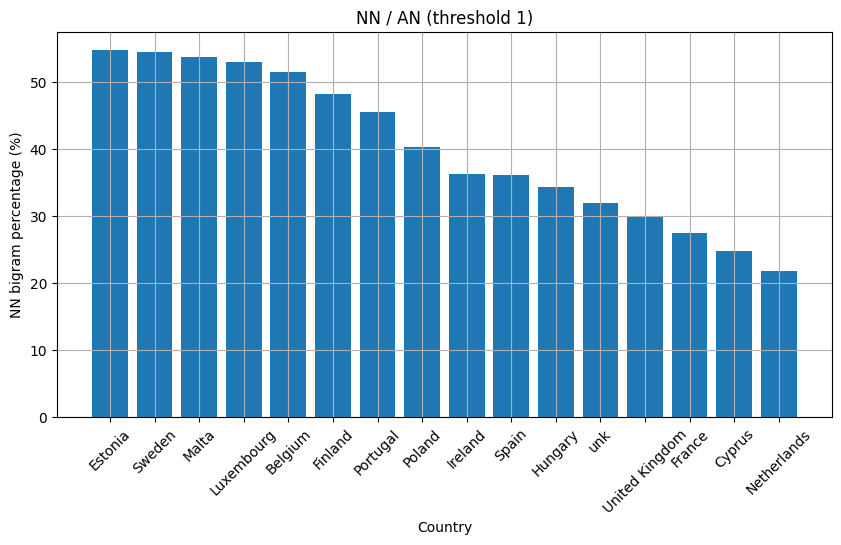

In [630]:
# threshold 1
calc_draw_an_nn(1)

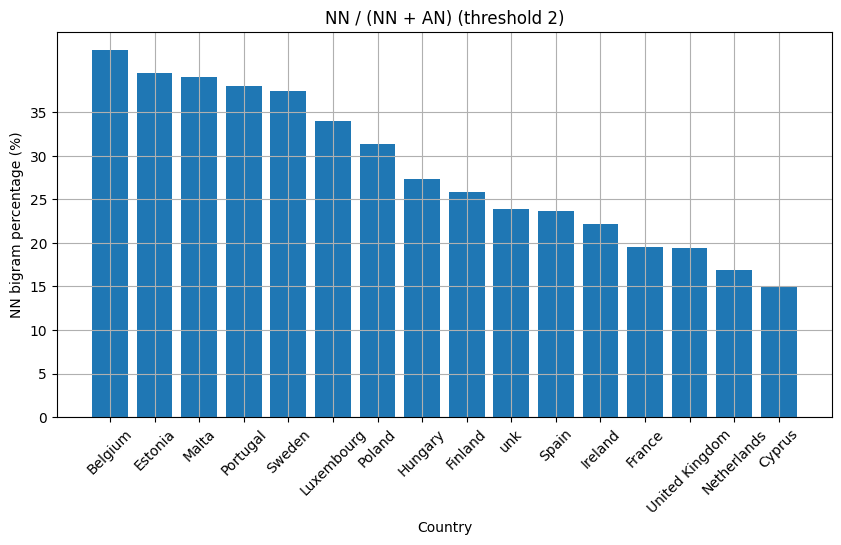

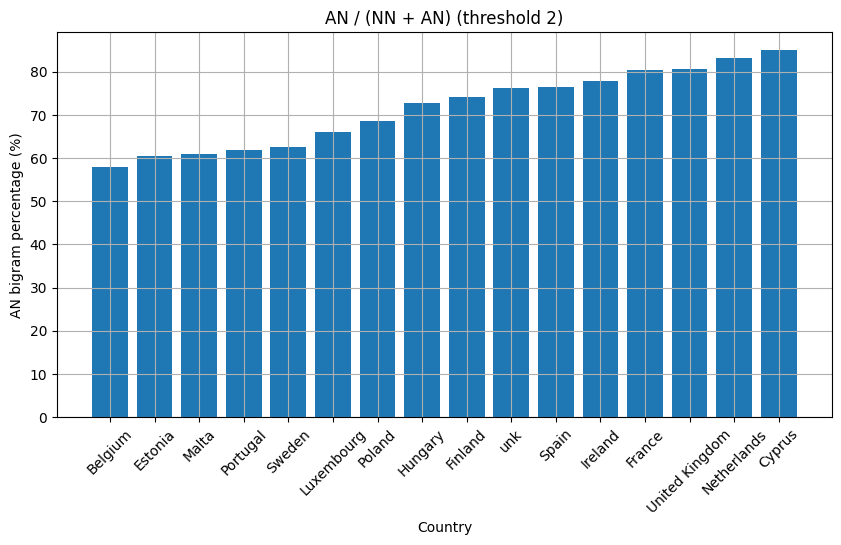

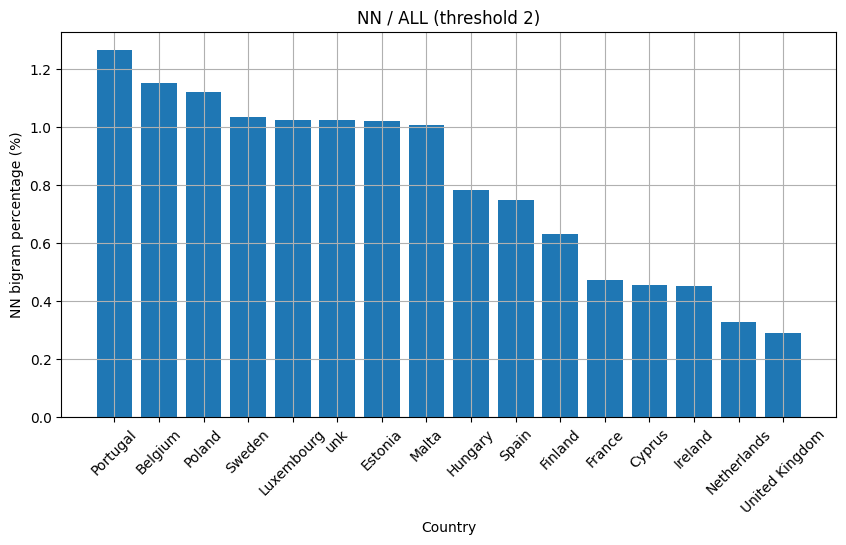

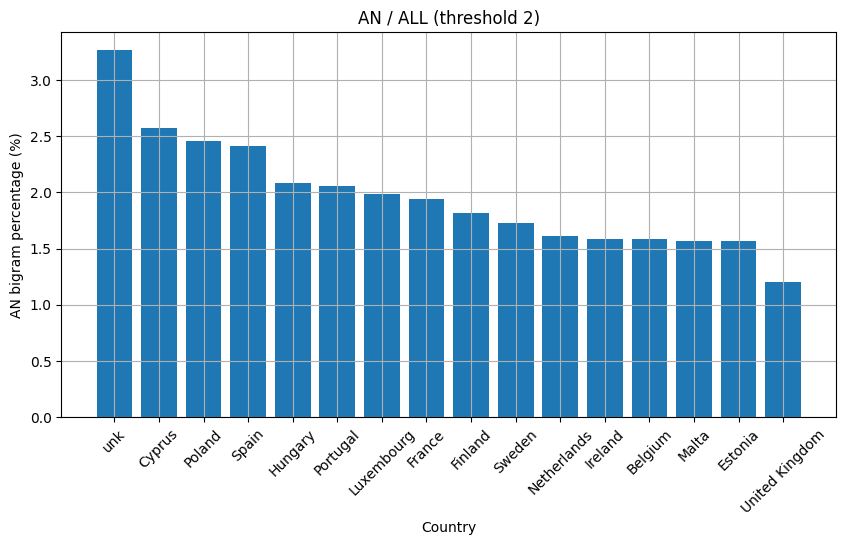

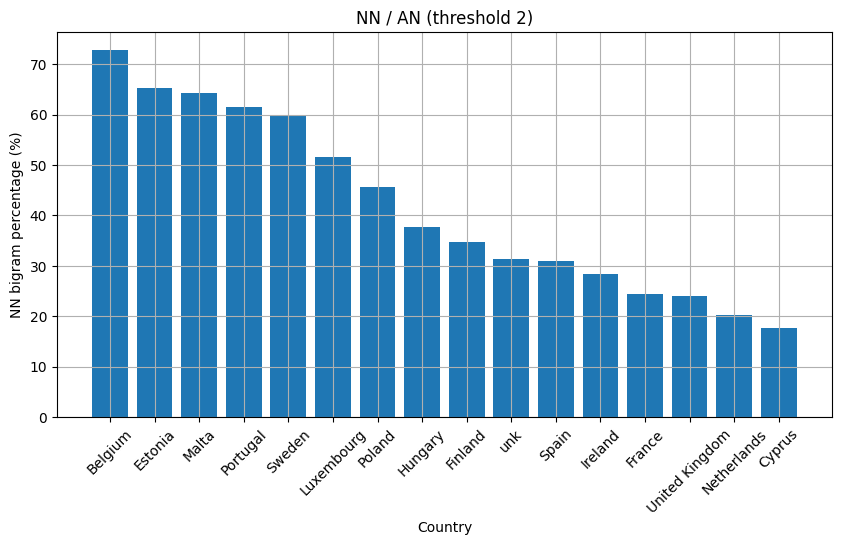

In [631]:
# threshold 2
calc_draw_an_nn(2)

#### <a id='toc8_4_3_1_'></a>[Alternative version (w/o threshold)](#toc0_)

In [478]:
df = pd.concat([df_natives_sample, df_nonnatives_sample])
state_list = df.state.unique()
freqs = {}
for state in state_list:
    df_ = df[df.state == state]
    freqs[state] = df_.NN_count.sum() / (df_.NN_count.sum() + df_.AN_count.sum()) * 100.

freqs_sorted = sorted(freqs.items(), key=lambda kv: kv[1], reverse=True)
print(*freqs_sorted, sep='\n')

('Luxembourg', np.float64(32.10702341137124))
('Malta', np.float64(30.349840981372108))
('Sweden', np.float64(29.77846470891293))
('Belgium', np.float64(29.32330827067669))
('Ireland', np.float64(27.823379564109825))
('Portugal', np.float64(27.803099361896077))
('Finland', np.float64(27.315054319710296))
('United Kingdom', np.float64(27.050222504767955))
('Spain', np.float64(26.982294072363356))
('Estonia', np.float64(26.712666338097584))
('Poland', np.float64(25.385356454720615))
('Cyprus', np.float64(23.505654281098547))
('Hungary', np.float64(22.898032200357783))
('Netherlands', np.float64(22.33834095362508))
('France', np.float64(19.389027431421447))


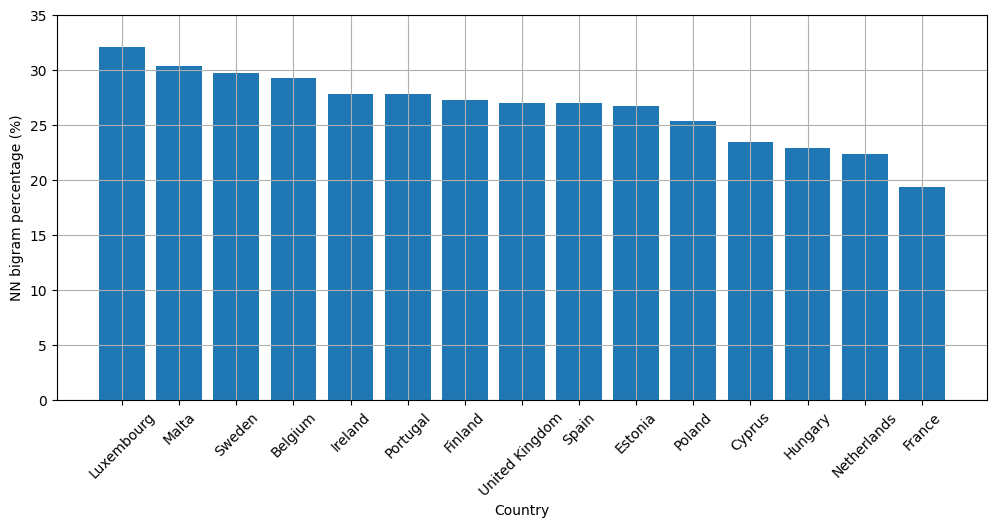

In [479]:
x, y = zip(*freqs_sorted)
plt.figure(figsize=(12,5))
plt.bar(x, y)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 40, step=5))
plt.xlabel('Country')
plt.ylabel('NN bigram percentage (%)')
plt.grid()
plt.show()

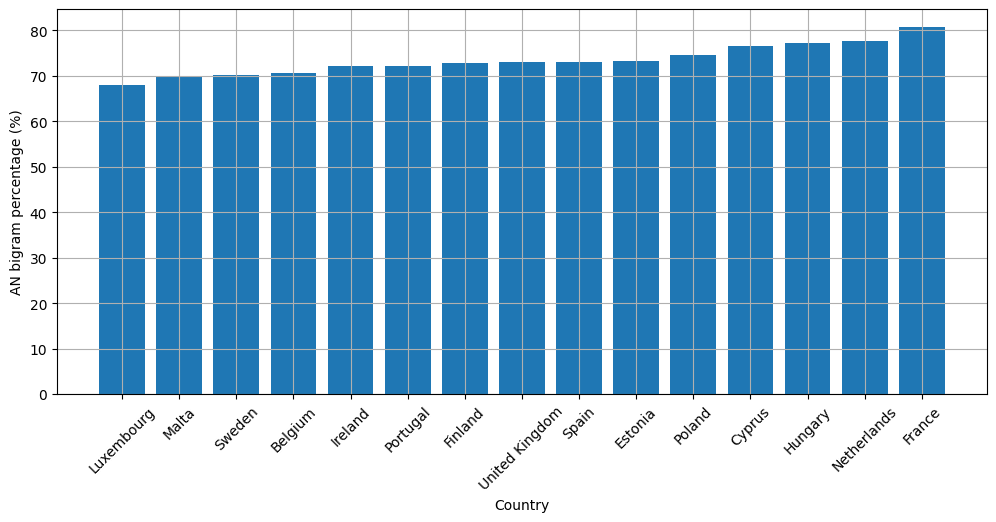

In [480]:
y_ = list(map(lambda v: 100. - v, y))
plt.figure(figsize=(12,5))
plt.bar(x, y_)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 90, step=10))
plt.xlabel('Country')
plt.ylabel('AN bigram percentage (%)')
plt.grid()
plt.show()

In [481]:
df = df_translations_sample
lang_list = df.lang.unique()
freqs = {}
for lang in lang_list:
    df_ = df[df.lang == lang]
    freqs[lang] = df_.NN_count.sum() / (df_.NN_count.sum() + df_.AN_count.sum()) * 100.

freqs_sorted = sorted(freqs.items(), key=lambda kv: kv[1], reverse=True)
print(*freqs_sorted, sep='\n')

('LT', np.float64(31.81973369750768))
('RO', np.float64(28.255528255528255))
('FI', np.float64(28.004235044997355))
('ET', np.float64(27.820267686424476))
('LV', np.float64(27.51736111111111))
('HU', np.float64(27.083333333333332))
('PT', np.float64(24.752475247524753))
('DE', np.float64(24.723829563387692))
('NL', np.float64(24.574780058651026))
('FR', np.float64(24.46650124069479))
('unk', np.float64(24.408602150537632))
('CS', np.float64(23.90557939914163))
('SK', np.float64(23.71978697255223))
('IT', np.float64(22.621397552309514))
('DA', np.float64(22.55343082114736))
('EL', np.float64(22.538552787663107))
('SV', np.float64(22.39674229203025))
('PL', np.float64(22.37512742099898))
('ES', np.float64(20.970782280867105))
('SL', np.float64(20.160150730098916))
('MT', np.float64(19.33019976498237))


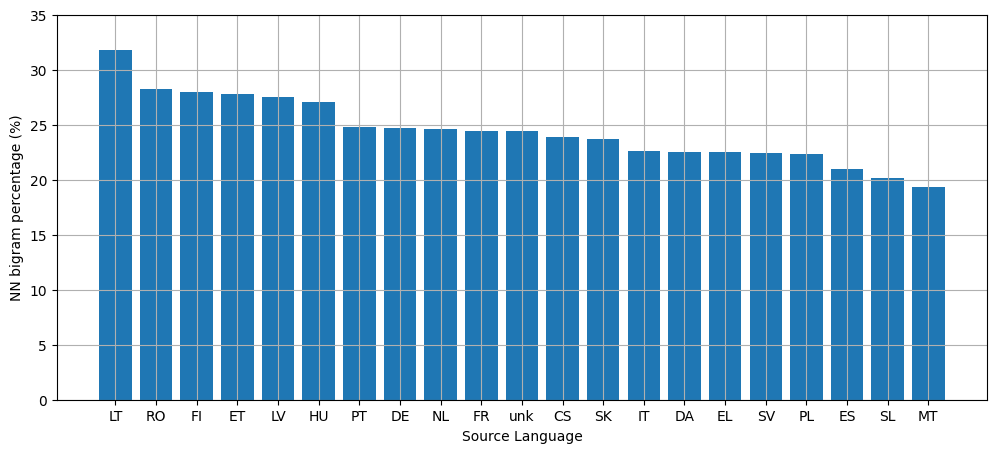

In [482]:
x, y = zip(*freqs_sorted)
plt.figure(figsize=(12,5))
plt.bar(x, y)
# plt.xticks(rotation=90)
plt.yticks(np.arange(0, 40, step=5))
plt.xlabel('Source Language')
plt.ylabel('NN bigram percentage (%)')
plt.grid()
plt.show()

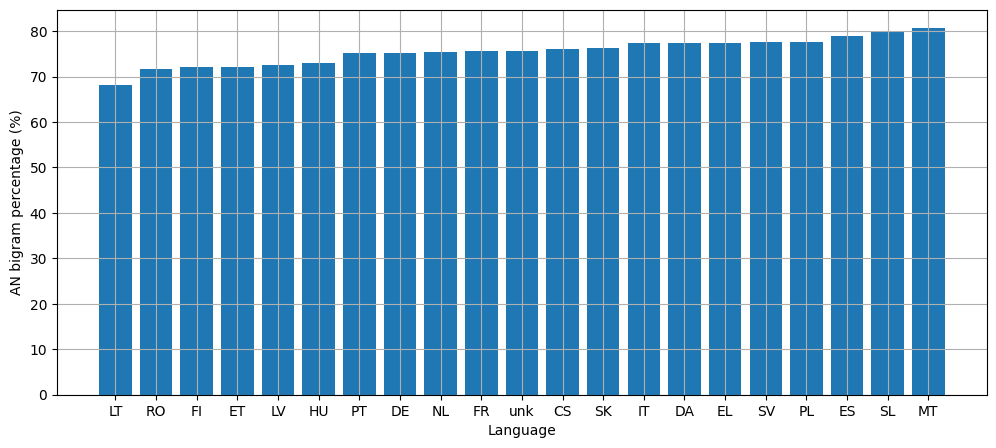

In [483]:
y_ = list(map(lambda v: 100. - v, y))
plt.figure(figsize=(12,5))
plt.bar(x, y_)
plt.yticks(np.arange(0, 90, step=10))
plt.xlabel('Language')
plt.ylabel('AN bigram percentage (%)')
plt.grid()
plt.show()

## <a id='toc8_5_'></a>[Collocations](#toc0_)

### <a id='toc8_5_1_'></a>[Bigrams](#toc0_)

In [633]:
# calculate bigram collocations with the window size specified
def calc_bigram_collocations_win(lemma_list, metric, win_size=2):
    finder_big_win = BigramCollocationFinder.from_words(lemma_list, window_size=win_size) # 2 by default
    return finder_big_win.score_ngrams(metric)

In [659]:
# Counter data to lists
def get_ngram_col_data(bigrams, n_common=10):
    x, y = zip(*bigrams[:n_common])
    # merging words
    x = [" ".join(t) for t in x]
    return x, y

In [634]:
BIGRAM_COL_MEASURE = bigram_measures.likelihood_ratio
BIGRAM_COL_WIN = 3

In [652]:
bigram_collocations = [calc_bigram_collocations_win(lem, BIGRAM_COL_MEASURE, BIGRAM_COL_WIN) for lem in lemmas_cleaner]

In [653]:
# natives
bigram_collocations[0][:15]

[(('would', 'like'), 304.3134949337086),
 (('human', 'right'), 231.6257923003414),
 (('take', 'place'), 88.78588423621608),
 (('common', 'policy'), 86.53735816382958),
 (('unite', 'kingdom'), 86.15329382353138),
 (('court', 'auditor'), 72.65226513226811),
 (('like', 'thank'), 67.51688471637857),
 (('northern', 'ireland'), 66.97252178188945),
 (('draw', 'attention'), 66.77179344773036),
 (('last', 'year'), 66.5353759215455),
 (('long', 'term'), 66.0572415053905),
 (('behalf', 'group'), 63.84705589075922),
 (('ppe', 'de'), 62.169367994088546),
 (('single', 'currency'), 62.16776601400275),
 (('committee', 'affair'), 58.46225059194168)]

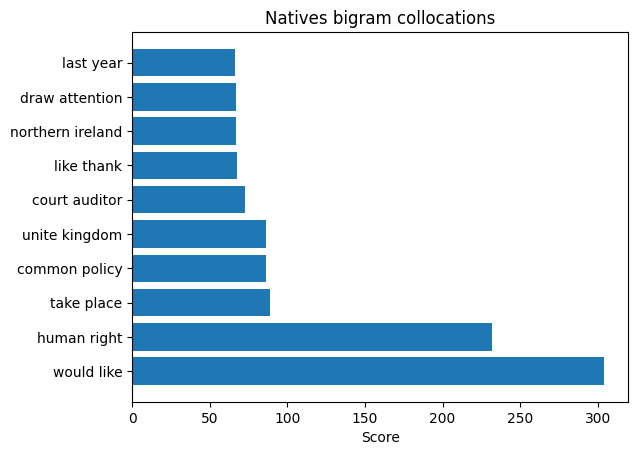

In [ ]:
x, y = get_ngram_col_data(bigram_collocations[0])
plt.barh(x, y)
plt.title("Natives bigram collocations")
plt.xlabel("Score")
plt.show()

In [654]:
# nonnatives
bigram_collocations[1][:15]

[(('would', 'like'), 1339.0219206319182),
 (('human', 'right'), 1215.7565515040517),
 (('take', 'account'), 348.7465341186728),
 (('behalf', 'group'), 333.9974266267472),
 (('like', 'thank'), 330.4531080223874),
 (('fundamental', 'right'), 320.2174204065697),
 (('eur', 'million'), 315.6585802399382),
 (('vote', 'favour'), 301.02824950792547),
 (('action', 'plan'), 265.1532199247969),
 (('alde', 'group'), 261.2115336432288),
 (('gender', 'equality'), 257.798471579982),
 (('lisbon', 'treaty'), 249.5244935710295),
 (('long', 'term'), 248.4327908407182),
 (('arrest', 'warrant'), 240.84863519123812),
 (('behalf', 'alde'), 236.34277431289337)]

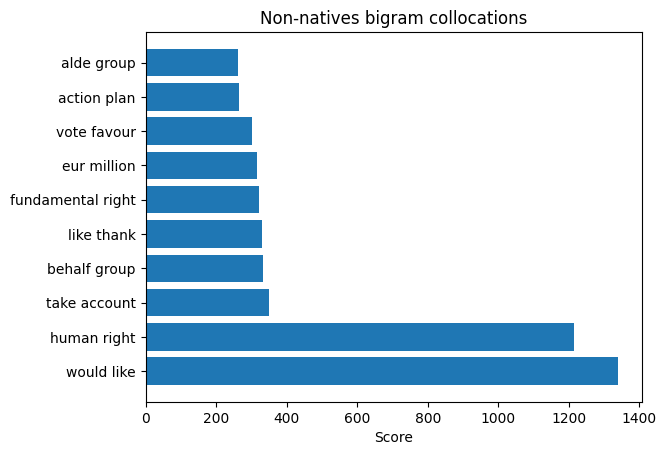

In [ ]:
x, y = get_ngram_col_data(bigram_collocations[1])
plt.barh(x, y)
plt.title("Non-natives bigram collocations")
plt.xlabel("Score")
plt.show()

In [655]:
# translations
bigram_collocations[2][:15]

[(('would', 'like'), 2816.39066191808),
 (('lady', 'gentleman'), 2217.565578333553),
 (('human', 'right'), 1610.0435719850177),
 (('vote', 'favour'), 807.3387724387234),
 (('like', 'thank'), 658.1772937138712),
 (('internal', 'market'), 653.7803423791771),
 (('take', 'account'), 583.0753039859379),
 (('medium', 'sized'), 569.7263018041906),
 (('eur', 'million'), 531.038125435578),
 (('take', 'place'), 506.9686147053201),
 (('small', 'medium'), 476.9369840602988),
 (('small', 'sized'), 473.9307900529613),
 (('climate', 'change'), 466.19225599767844),
 (('long', 'term'), 453.44652626735126),
 (('young', 'person'), 444.6626955174486)]

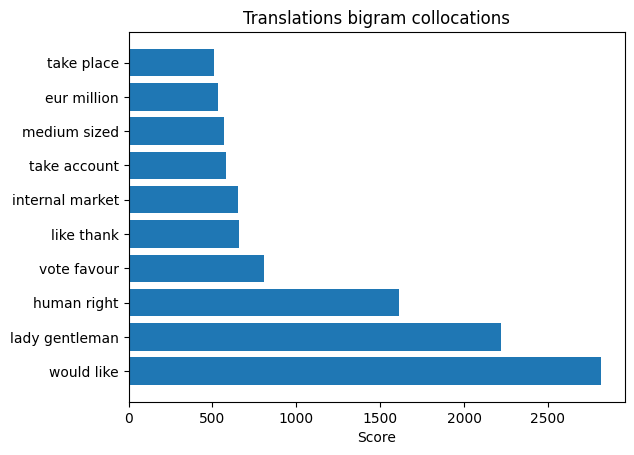

In [670]:
x, y = get_ngram_col_data(bigram_collocations[2])
plt.barh(x, y)
plt.title("Translations bigram collocations")
plt.xlabel("Score")
plt.show()

### <a id='toc8_5_2_'></a>[Trigrams](#toc0_)

In [664]:
def calc_trigram_collocations_win(lemma_list, metric, win_size=2):
    finder_trig_win = TrigramCollocationFinder.from_words(lemma_list, window_size=win_size) # 2 by default
    return finder_trig_win.score_ngrams(metric)

In [665]:
TRIGRAM_COL_MEASURE = trigram_measures.likelihood_ratio
TRIGRAM_COL_WIN = 3

In [666]:
trigram_collocations = [calc_trigram_collocations_win(lem, TRIGRAM_COL_MEASURE, TRIGRAM_COL_WIN) for lem in lemmas_cleaner]

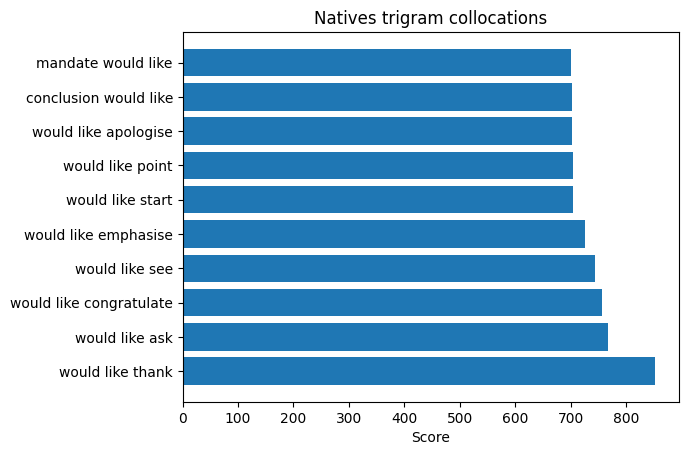

In [667]:
x, y = get_ngram_col_data(trigram_collocations[0])
plt.barh(x, y)
plt.title("Natives trigram collocations")
plt.xlabel("Score")
plt.show()

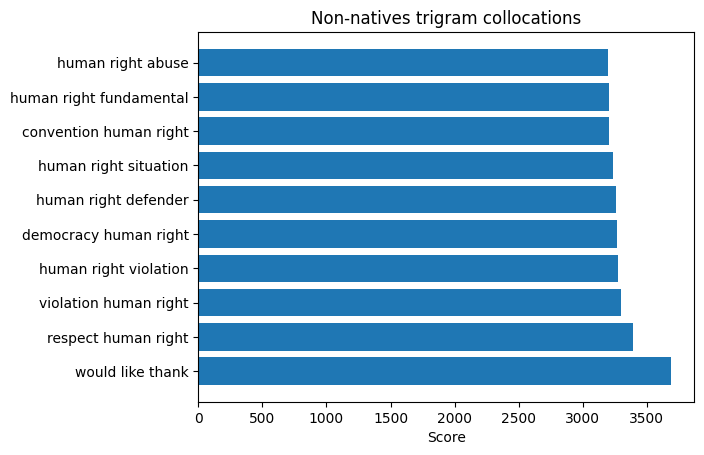

In [668]:
x, y = get_ngram_col_data(trigram_collocations[1])
plt.barh(x, y)
plt.title("Non-natives trigram collocations")
plt.xlabel("Score")
plt.show()

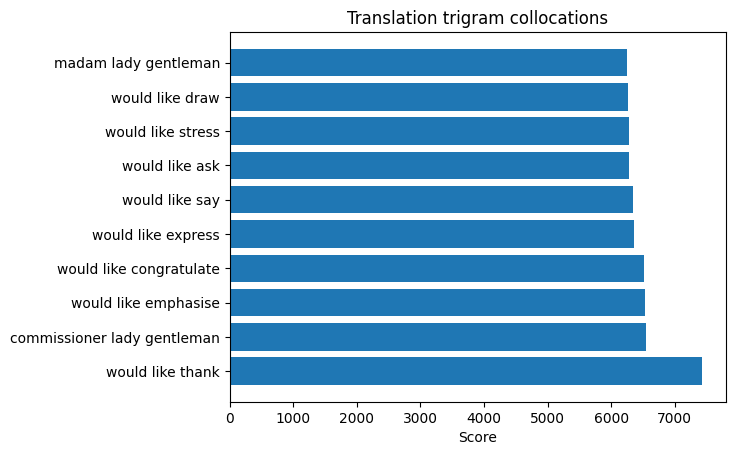

In [669]:
x, y = get_ngram_col_data(trigram_collocations[2])
plt.barh(x, y)
plt.title("Translation trigram collocations")
plt.xlabel("Score")
plt.show()